## Model Optimization for Diverse Classification Tasks

---
#### 1. Dataset Cleaning & Processing for BrinjalFruitX
---

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import json

# --- 1. Configuration ---
# Define paths and parameters
RAW_DATA_DIR = os.path.join('raw_data', 'BrinjalFruitX')
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
IMG_SIZE = (224, 224)
TEST_SPLIT_SIZE = 0.20 # 20% for the final test set
VALIDATION_SPLIT_SIZE = 0.125 # 10% of the original data (0.125 * 0.8 = 0.1)
RANDOM_STATE = 42 # For reproducible splits

# --- 2. Create Processed Data Directory ---
# This ensures the folder exists before we try to save files to it.
os.makedirs(PROCESSED_DIR, exist_ok=True)
print(f"Directory '{PROCESSED_DIR}' is ready.")

# --- 3. Load Images and Labels ---
images = []
labels = []

# Get class names from the folder names in the raw data directory
class_names = sorted([d for d in os.listdir(RAW_DATA_DIR) if os.path.isdir(os.path.join(RAW_DATA_DIR, d))])
# Create a mapping from class name to an integer index
label_map = {name: i for i, name in enumerate(class_names)}

print("Starting image loading and preprocessing...")
# Use tqdm for a progress bar
for class_name in tqdm(class_names, desc="Processing classes"):
    class_path = os.path.join(RAW_DATA_DIR, class_name)
    class_label = label_map[class_name]

    for image_file in os.listdir(class_path):
        image_path = os.path.join(class_path, image_file)

        # Read the image
        image = cv2.imread(image_path)

        # Check if the image was loaded correctly
        if image is not None:
            # Convert image from BGR (OpenCV's default) to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # Resize image to the standard size
            image = cv2.resize(image, IMG_SIZE)
            
            images.append(image)
            labels.append(class_label)
        else:
            print(f"Warning: Could not read image {image_path}. Skipping.")

print("Image loading complete.")

# --- 4. Convert to NumPy Arrays and Normalize ---
# Convert lists to NumPy arrays for efficient processing
images_np = np.array(images)
labels_np = np.array(labels)

# Normalize pixel values from the [0, 255] range to the [0.0, 1.0] range
images_np = images_np / 255.0

print(f"Converted to NumPy arrays. Image data shape: {images_np.shape}, Labels shape: {labels_np.shape}")

# --- 5. Split the Data ---
# First split: separate out the 20% test set
X_train_val, X_test, y_train_val, y_test = train_test_split(
    images_np,
    labels_np,
    test_size=TEST_SPLIT_SIZE,
    random_state=RANDOM_STATE,
    stratify=labels_np  # Ensures class distribution is similar across splits
)

# Second split: separate the remaining data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=VALIDATION_SPLIT_SIZE, # 0.125 of the 80% results in 10% of the original data
    random_state=RANDOM_STATE,
    stratify=y_train_val # Stratify again for the validation split
)

print("Data splitting complete:")
print(f"  Training set:   {X_train.shape[0]} samples")
print(f"  Validation set: {X_val.shape[0]} samples")
print(f"  Test set:       {X_test.shape[0]} samples")

# --- 6. Save the Processed Data ---
print("Saving processed data to .npy files...")

np.save(os.path.join(PROCESSED_DIR, 'X_train.npy'), X_train)
np.save(os.path.join(PROCESSED_DIR, 'y_train.npy'), y_train)

np.save(os.path.join(PROCESSED_DIR, 'X_val.npy'), X_val)
np.save(os.path.join(PROCESSED_DIR, 'y_val.npy'), y_val)

np.save(os.path.join(PROCESSED_DIR, 'X_test.npy'), X_test)
np.save(os.path.join(PROCESSED_DIR, 'y_test.npy'), y_test)

# Save the class names/label map for later use in decoding predictions
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'w') as f:
    json.dump(class_names, f)

print("All data has been processed and saved successfully! ✅")

Directory 'processed_data' is ready.
Starting image loading and preprocessing...


Processing classes: 100%|██████████| 5/5 [00:55<00:00, 11.11s/it]


Image loading complete.
Converted to NumPy arrays. Image data shape: (1802, 224, 224, 3), Labels shape: (1802,)
Data splitting complete:
  Training set:   1260 samples
  Validation set: 181 samples
  Test set:       361 samples
Saving processed data to .npy files...
All data has been processed and saved successfully! ✅


---
#### 2. Training and Testing on Baseline Models
---

Model: MobileNetv2

Learning Rate: 0.0001

Batch Size: 8

Max EPOCH = 100

Patience = 15

Time Taken = 18 min 56 sec

Loading preprocessed data...
Data loaded successfully.

Starting mobilenetv2_bs8_0.0001_lr model training...
Epoch 1/100
157/158 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.2119 - loss: 2.2692
Epoch 1: val_loss improved from inf to 1.34475, saving model to results\mobilenetv2_bs8_0.0001_lr\best_model.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.2127 - loss: 2.2657 - val_accuracy: 0.4586 - val_loss: 1.3447
Epoch 2/100
157/158 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.4399 - loss: 1.5128
Epoch 2: val_loss improved from 1.34475 to 1.14300, saving model to results\mobilenetv2_bs8_0.0001_lr\best_model.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.4396 - loss: 1.5131 - val_accuracy: 0.5801 - val_loss: 1.1430
Epoch 3/100
157/158 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5034 - loss: 1.3276
Epoch 3: val_loss improved from 1.14300 to 0.99551, saving model to results\mobilenetv2_bs8_0.0001_lr\best_model.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 66m

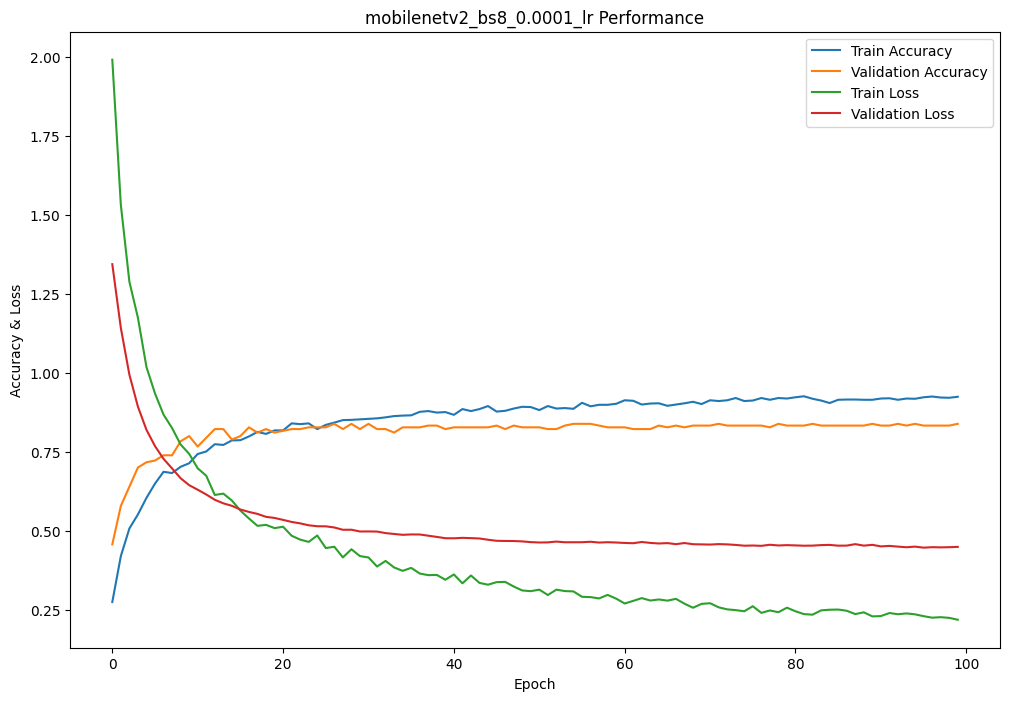


--- mobilenetv2_bs8_0.0001_lr Validation Set Evaluation ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 336ms/step

Validation Set Classification Report:

                        precision    recall  f1-score   support

Brinjal Fruit Creaking       0.80      0.60      0.69        20
        Healty Brinjal       0.88      0.94      0.91        52
      Phomopsis Bright       0.71      0.62      0.67        16
 Shoot and Fruit Borer       0.84      0.86      0.85        73
               Wet Rot       0.81      0.85      0.83        20

              accuracy                           0.83       181
             macro avg       0.81      0.78      0.79       181
          weighted avg       0.83      0.83      0.83       181


--- mobilenetv2_bs8_0.0001_lr Final Test Set Evaluation ---
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step

Test Set Classification Report:

                        precision    recall  f1-score   support

Brinjal Fruit Creaking       0.73      0.82      0.78        40
        Healty B

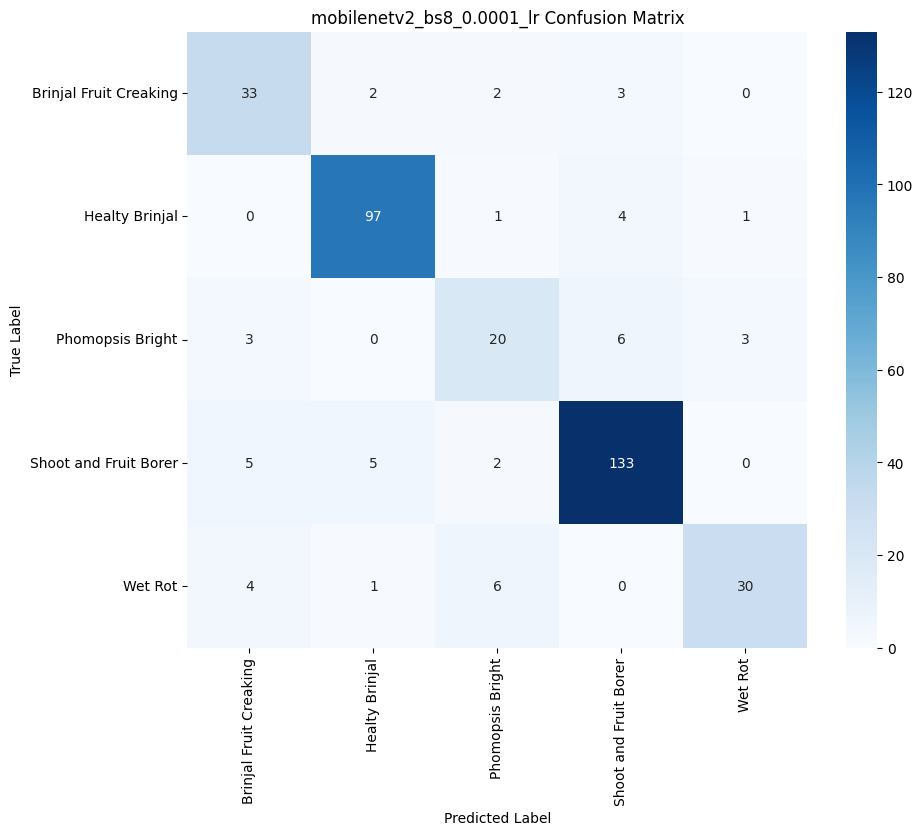


Updating summary results file...
Updated results for mobilenetv2_bs8_0.0001_lr in results\summary_results.csv

The best version of mobilenetv2_bs8_0.0001_lr was saved to 'results\mobilenetv2_bs8_0.0001_lr\best_model.keras'


In [5]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
MODEL_NAME = 'mobilenetv2_bs8_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (MobileNetV2) ---
EPOCHS = 100
BATCH_SIZE = 8

# --- Learning Rate Configuration & Callbacks ---
INITIAL_LR = 0.0001
DECAY_RATE = 0.96
DECAY_STEPS = 1000

PATIENCE = 15

# def lr_scheduler(epoch, lr):
#     return INITIAL_LR * DECAY_RATE**(epoch * (X_train.shape[0] // BATCH_SIZE) / DECAY_STEPS)

early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

# lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)
# callbacks_list = [early_stopping, model_checkpoint, lr_callback]
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
# --- MODIFIED: Merged into a single plot to match the paper's style ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
# --- ADDED: Detailed report for the VALIDATION set ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

# --- Evaluation on the TEST set remains the same ---
print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

# --- Saving the Test Set report and Confusion Matrix ---
report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
# This section remains the same
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: MobileNetv2

Learning Rate: 0.00001

Batch Size: 8

Max EPOCH = 100

Patience = 15

Time Taken = 18 min 1 sec

Loading preprocessed data...
Data loaded successfully.

Starting mobilenetv2_bs8_0.00001_lr model training...
Epoch 1/100
157/158 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.2040 - loss: 2.3381
Epoch 1: val_loss improved from inf to 1.73161, saving model to results\mobilenetv2_bs8_0.00001_lr\best_model.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.2042 - loss: 2.3373 - val_accuracy: 0.2818 - val_loss: 1.7316
Epoch 2/100
157/158 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2222 - loss: 2.1400
Epoch 2: val_loss improved from 1.73161 to 1.58188, saving model to results\mobilenetv2_bs8_0.00001_lr\best_model.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.2224 - loss: 2.1390 - val_accuracy: 0.2983 - val_loss: 1.5819
Epoch 3/100
157/158 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.2730 - loss: 1.9454
Epoch 3: val_loss improved from 1.58188 to 1.49043, saving model to results\mobilenetv2_bs8_0.00001_lr\best_model.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s

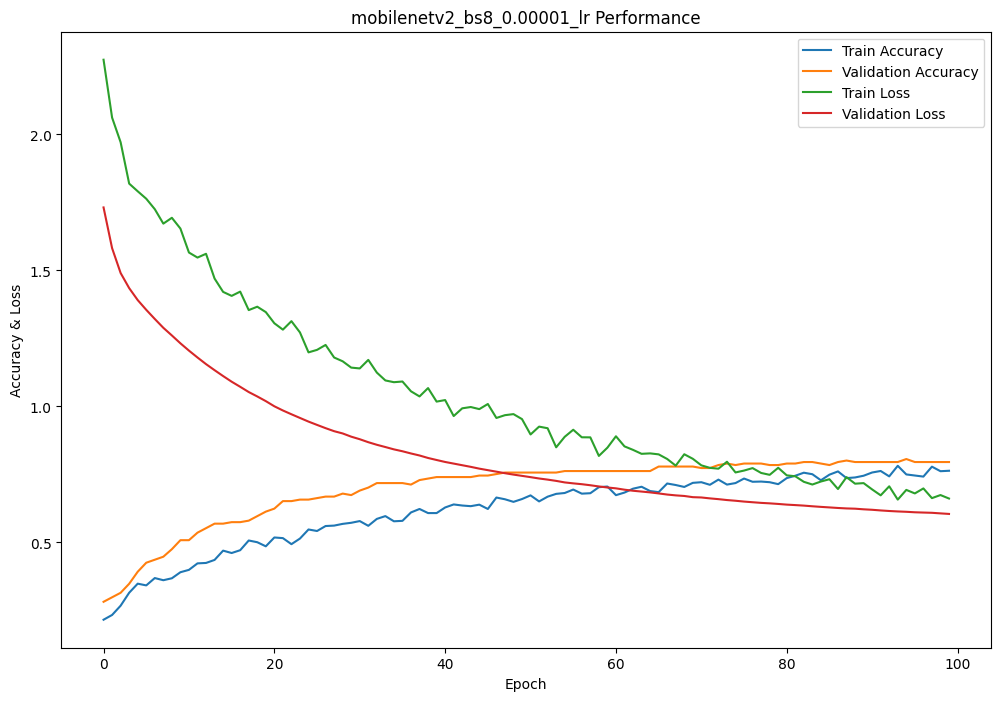


--- mobilenetv2_bs8_0.00001_lr Validation Set Evaluation ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 326ms/step

Validation Set Classification Report:

                        precision    recall  f1-score   support

Brinjal Fruit Creaking       0.85      0.55      0.67        20
        Healty Brinjal       0.84      0.90      0.87        52
      Phomopsis Bright       0.56      0.31      0.40        16
 Shoot and Fruit Borer       0.80      0.86      0.83        73
               Wet Rot       0.75      0.90      0.82        20

              accuracy                           0.80       181
             macro avg       0.76      0.71      0.72       181
          weighted avg       0.79      0.80      0.78       181


--- mobilenetv2_bs8_0.00001_lr Final Test Set Evaluation ---
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step

Test Set Classification Report:

                        precision    recall  f1-score   support

Brinjal Fruit Creaking       0.75      0.60      0.67        40
        Healty

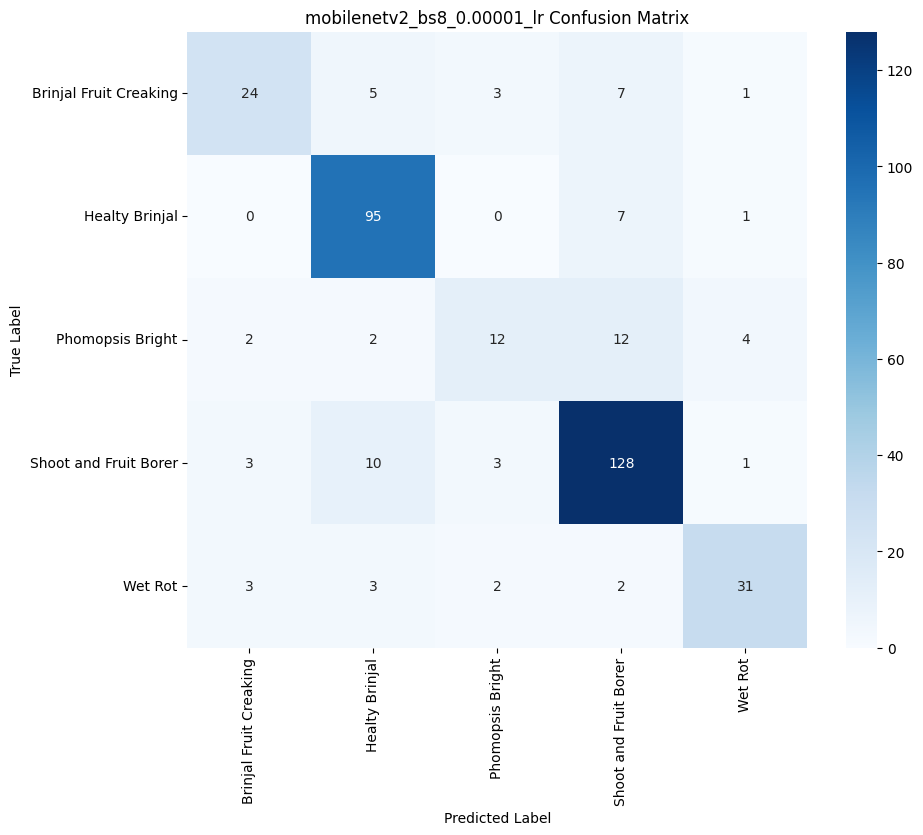


Updating summary results file...
Updated results for mobilenetv2_bs8_0.00001_lr in results\summary_results.csv

The best version of mobilenetv2_bs8_0.00001_lr was saved to 'results\mobilenetv2_bs8_0.00001_lr\best_model.keras'


In [6]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
MODEL_NAME = 'mobilenetv2_bs8_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (MobileNetV2) ---
EPOCHS = 100
BATCH_SIZE = 8

# --- Learning Rate Configuration & Callbacks ---
INITIAL_LR = 0.00001
DECAY_RATE = 0.96
DECAY_STEPS = 1000

PATIENCE = 15

# def lr_scheduler(epoch, lr):
#     return INITIAL_LR * DECAY_RATE**(epoch * (X_train.shape[0] // BATCH_SIZE) / DECAY_STEPS)

early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

# lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)
# callbacks_list = [early_stopping, model_checkpoint, lr_callback]
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
# --- MODIFIED: Merged into a single plot to match the paper's style ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
# --- ADDED: Detailed report for the VALIDATION set ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

# --- Evaluation on the TEST set remains the same ---
print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

# --- Saving the Test Set report and Confusion Matrix ---
report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
# This section remains the same
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: MobileNetv2

Learning Rate: 0.0001

Batch Size: 16

Max EPOCH = 100

Patience = 15

Time Taken = 14 min 52 sec

Loading preprocessed data...
Data loaded successfully.

Starting mobilenetv2_bs16_0.0001_lr model training...
Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.2633 - loss: 2.0980
Epoch 1: val_loss improved from inf to 1.43293, saving model to results\mobilenetv2_bs16_0.0001_lr\best_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - accuracy: 0.2638 - loss: 2.0961 - val_accuracy: 0.4641 - val_loss: 1.4329
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.3985 - loss: 1.6868
Epoch 2: val_loss improved from 1.43293 to 1.23729, saving model to results\mobilenetv2_bs16_0.0001_lr\best_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.3986 - loss: 1.6865 - val_accuracy: 0.5249 - val_loss: 1.2373
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.4556 - loss: 1.4811
Epoch 3: val_loss improved from 1.23729 to 1.11544, saving model to results\mobilenetv2_bs16_0.0001_lr\best_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step

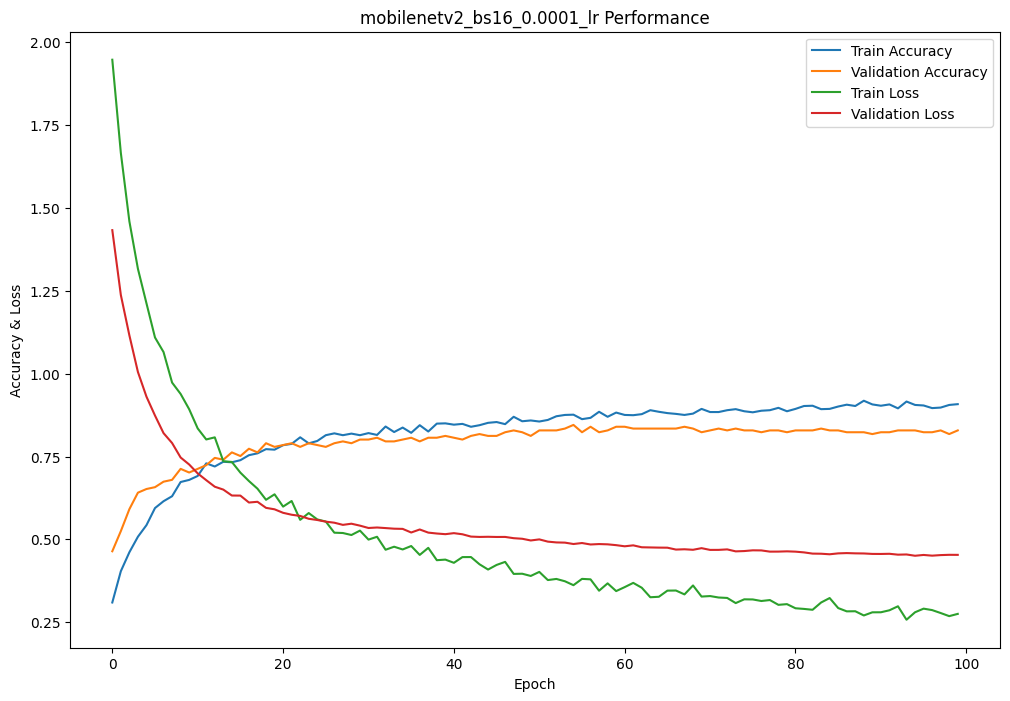


--- mobilenetv2_bs16_0.0001_lr Validation Set Evaluation ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 329ms/step

Validation Set Classification Report:

                        precision    recall  f1-score   support

Brinjal Fruit Creaking       0.80      0.60      0.69        20
        Healty Brinjal       0.87      0.92      0.90        52
      Phomopsis Bright       0.71      0.62      0.67        16
 Shoot and Fruit Borer       0.84      0.86      0.85        73
               Wet Rot       0.77      0.85      0.81        20

              accuracy                           0.83       181
             macro avg       0.80      0.77      0.78       181
          weighted avg       0.83      0.83      0.83       181


--- mobilenetv2_bs16_0.0001_lr Final Test Set Evaluation ---
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step

Test Set Classification Report:

                        precision    recall  f1-score   support

Brinjal Fruit Creaking       0.74      0.85      0.79        40
        Healty

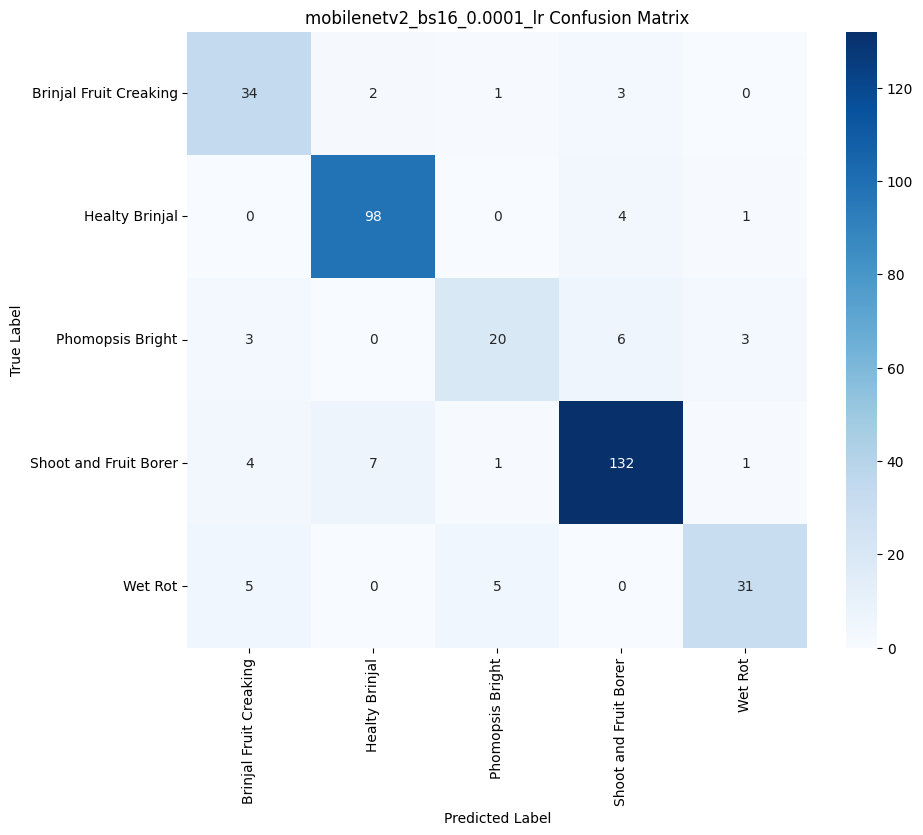


Updating summary results file...
Updated results for mobilenetv2_bs16_0.0001_lr in results\summary_results.csv

The best version of mobilenetv2_bs16_0.0001_lr was saved to 'results\mobilenetv2_bs16_0.0001_lr\best_model.keras'


In [7]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
MODEL_NAME = 'mobilenetv2_bs16_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (MobileNetV2) ---
EPOCHS = 100
BATCH_SIZE = 16

# --- Learning Rate Configuration & Callbacks ---
INITIAL_LR = 0.0001
DECAY_RATE = 0.96
DECAY_STEPS = 1000

PATIENCE = 15

# def lr_scheduler(epoch, lr):
#     return INITIAL_LR * DECAY_RATE**(epoch * (X_train.shape[0] // BATCH_SIZE) / DECAY_STEPS)

early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

# lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)
# callbacks_list = [early_stopping, model_checkpoint, lr_callback]
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
# --- MODIFIED: Merged into a single plot to match the paper's style ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
# --- ADDED: Detailed report for the VALIDATION set ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

# --- Evaluation on the TEST set remains the same ---
print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

# --- Saving the Test Set report and Confusion Matrix ---
report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
# This section remains the same
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: MobileNetv2

Learning Rate: 0.00001

Batch Size: 16

Max EPOCH = 100

Patience = 15

Time Taken = 14 min 52 sec

Loading preprocessed data...
Data loaded successfully.

Starting mobilenetv2_bs16_0.00001_lr model training...
Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.1160 - loss: 3.0874
Epoch 1: val_loss improved from inf to 2.55362, saving model to results\mobilenetv2_bs16_0.00001_lr\best_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - accuracy: 0.1159 - loss: 3.0864 - val_accuracy: 0.1105 - val_loss: 2.5536
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.1129 - loss: 2.8690
Epoch 2: val_loss improved from 2.55362 to 2.26499, saving model to results\mobilenetv2_bs16_0.00001_lr\best_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - accuracy: 0.1130 - loss: 2.8678 - val_accuracy: 0.1215 - val_loss: 2.2650
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.1542 - loss: 2.5263
Epoch 3: val_loss improved from 2.26499 to 2.04530, saving model to results\mobilenetv2_bs16_0.00001_lr\best_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/s

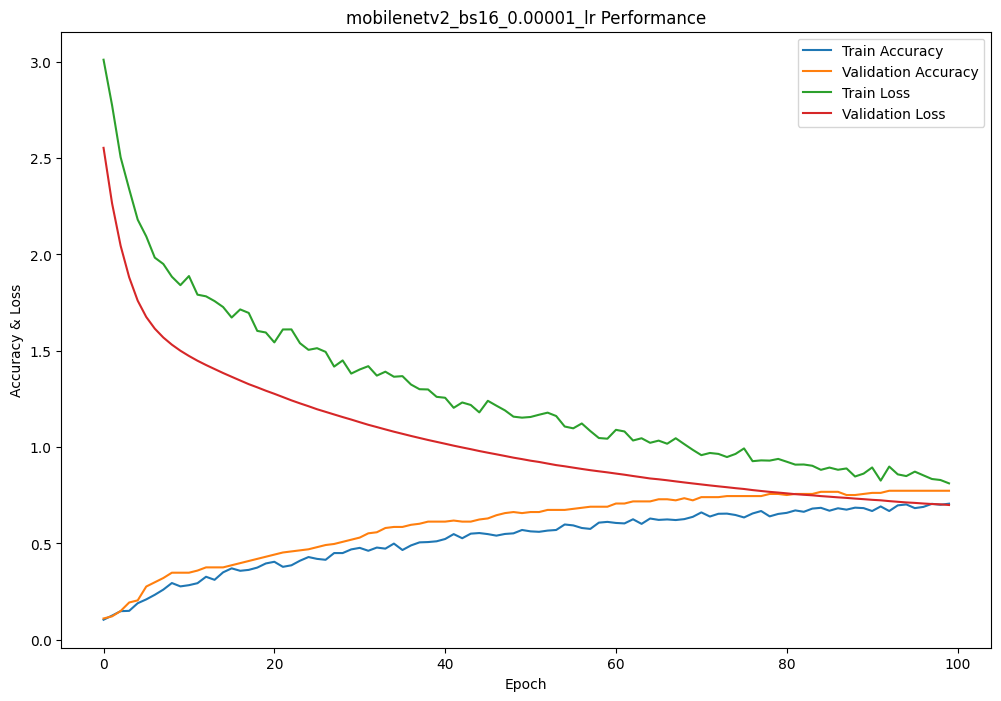


--- mobilenetv2_bs16_0.00001_lr Validation Set Evaluation ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 430ms/step

Validation Set Classification Report:

                        precision    recall  f1-score   support

Brinjal Fruit Creaking       0.73      0.40      0.52        20
        Healty Brinjal       0.82      0.90      0.86        52
      Phomopsis Bright       0.57      0.25      0.35        16
 Shoot and Fruit Borer       0.75      0.88      0.81        73
               Wet Rot       0.81      0.85      0.83        20

              accuracy                           0.77       181
             macro avg       0.74      0.66      0.67       181
          weighted avg       0.76      0.77      0.75       181


--- mobilenetv2_bs16_0.00001_lr Final Test Set Evaluation ---
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step

Test Set Classification Report:

                        precision    recall  f1-score   support

Brinjal Fruit Creaking       0.81      0.53      0.64        40
        Heal

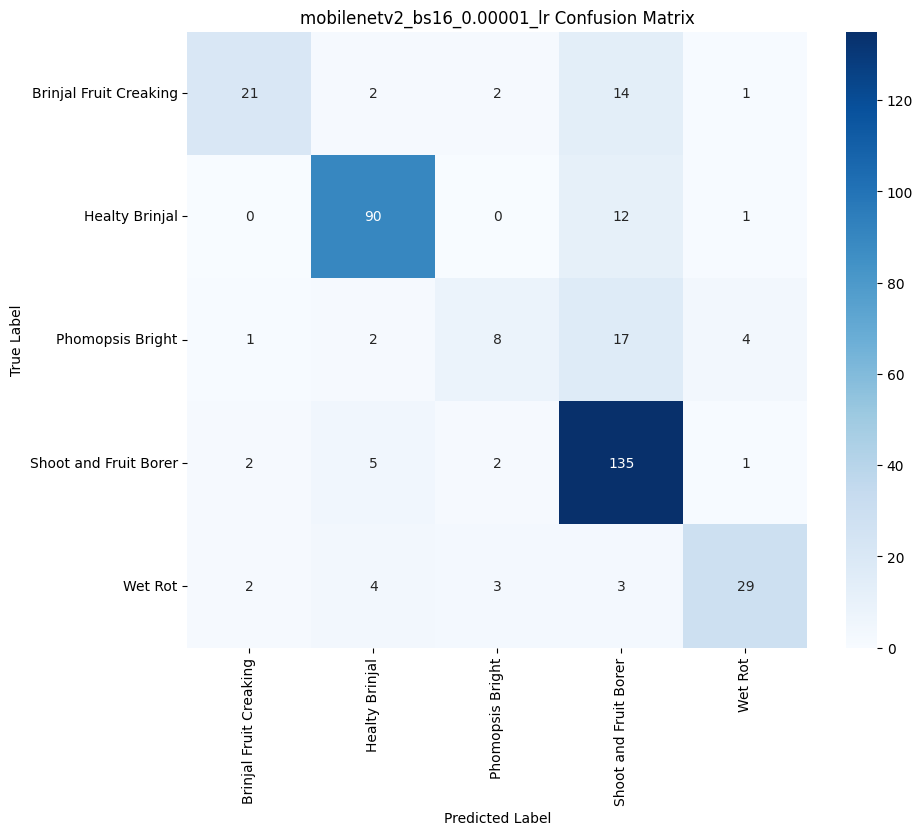


Updating summary results file...
Updated results for mobilenetv2_bs16_0.00001_lr in results\summary_results.csv

The best version of mobilenetv2_bs16_0.00001_lr was saved to 'results\mobilenetv2_bs16_0.00001_lr\best_model.keras'


In [8]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
MODEL_NAME = 'mobilenetv2_bs16_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (MobileNetV2) ---
EPOCHS = 100
BATCH_SIZE = 16

# --- Learning Rate Configuration & Callbacks ---
INITIAL_LR = 0.00001
DECAY_RATE = 0.96
DECAY_STEPS = 1000

PATIENCE = 15

# def lr_scheduler(epoch, lr):
#     return INITIAL_LR * DECAY_RATE**(epoch * (X_train.shape[0] // BATCH_SIZE) / DECAY_STEPS)

early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

# lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)
# callbacks_list = [early_stopping, model_checkpoint, lr_callback]
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
# --- MODIFIED: Merged into a single plot to match the paper's style ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
# --- ADDED: Detailed report for the VALIDATION set ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

# --- Evaluation on the TEST set remains the same ---
print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

# --- Saving the Test Set report and Confusion Matrix ---
report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
# This section remains the same
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: MobileNetv2

Learning Rate: 0.0001

Batch Size: 32

Max EPOCH = 100

Patience = 15

Time Taken = 13 min 08 sec

Loading preprocessed data...
Data loaded successfully.

Starting mobilenetv2_bs32_0.0001_lr model training...
Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.2046 - loss: 2.0499
Epoch 1: val_loss improved from inf to 1.38918, saving model to results\mobilenetv2_bs32_0.0001_lr\best_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 223ms/step - accuracy: 0.2059 - loss: 2.0469 - val_accuracy: 0.4530 - val_loss: 1.3892
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.3899 - loss: 1.6705
Epoch 2: val_loss improved from 1.38918 to 1.26723, saving model to results\mobilenetv2_bs32_0.0001_lr\best_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 193ms/step - accuracy: 0.3900 - loss: 1.6699 - val_accuracy: 0.5193 - val_loss: 1.2672
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.4242 - loss: 1.5351
Epoch 3: val_loss improved from 1.26723 to 1.16112, saving model to results\mobilenetv2_bs32_0.0001_lr\best_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 191ms/st

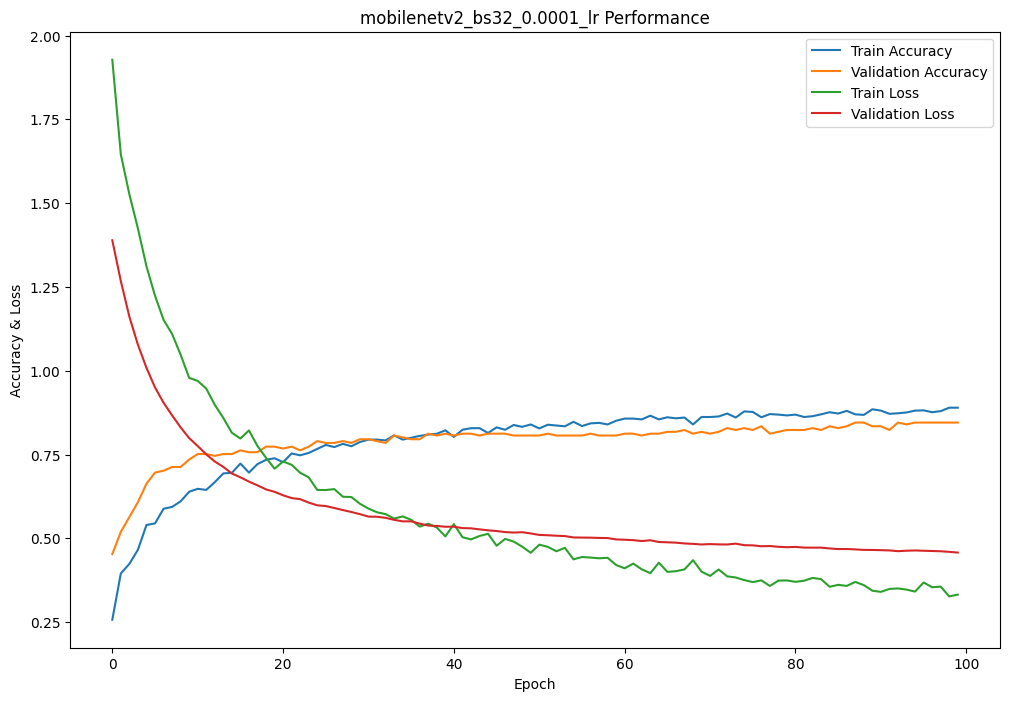


--- mobilenetv2_bs32_0.0001_lr Validation Set Evaluation ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 326ms/step

Validation Set Classification Report:

                        precision    recall  f1-score   support

Brinjal Fruit Creaking       0.79      0.55      0.65        20
        Healty Brinjal       0.88      0.96      0.92        52
      Phomopsis Bright       0.83      0.62      0.71        16
 Shoot and Fruit Borer       0.84      0.88      0.86        73
               Wet Rot       0.82      0.90      0.86        20

              accuracy                           0.85       181
             macro avg       0.83      0.78      0.80       181
          weighted avg       0.84      0.85      0.84       181


--- mobilenetv2_bs32_0.0001_lr Final Test Set Evaluation ---
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step

Test Set Classification Report:

                        precision    recall  f1-score   support

Brinjal Fruit Creaking       0.73      0.80      0.76        40
        Healty

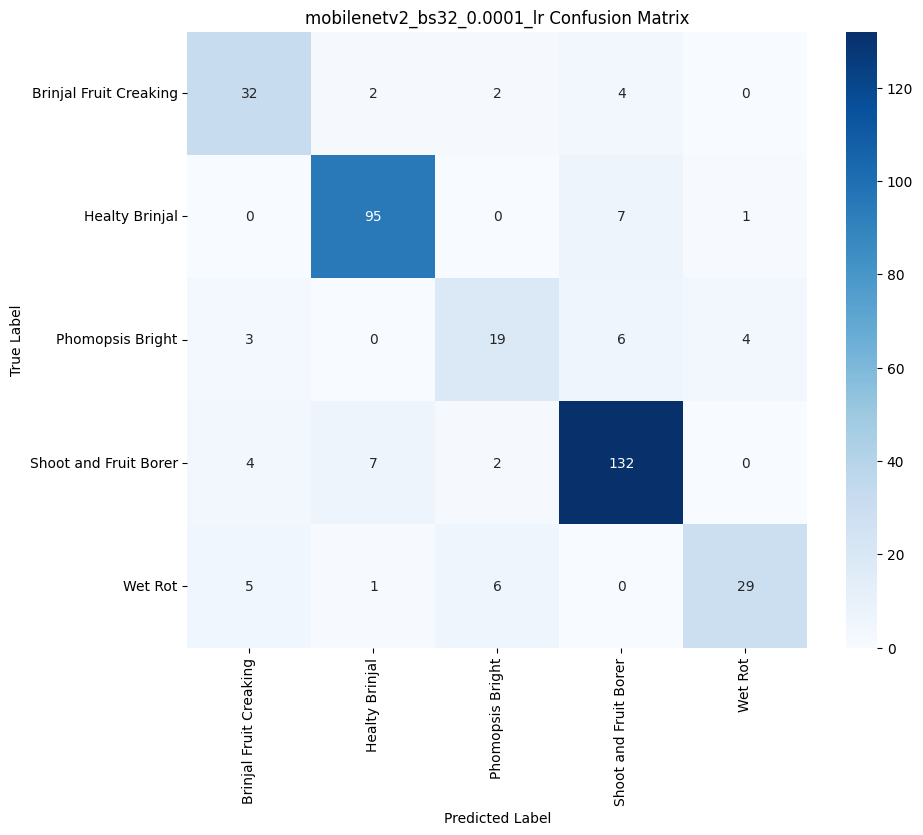


Updating summary results file...
Updated results for mobilenetv2_bs32_0.0001_lr in results\summary_results.csv

The best version of mobilenetv2_bs32_0.0001_lr was saved to 'results\mobilenetv2_bs32_0.0001_lr\best_model.keras'


In [9]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
MODEL_NAME = 'mobilenetv2_bs32_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (MobileNetV2) ---
EPOCHS = 100
BATCH_SIZE = 32

# --- Learning Rate Configuration & Callbacks ---
INITIAL_LR = 0.0001
DECAY_RATE = 0.96
DECAY_STEPS = 1000

PATIENCE = 15

# def lr_scheduler(epoch, lr):
#     return INITIAL_LR * DECAY_RATE**(epoch * (X_train.shape[0] // BATCH_SIZE) / DECAY_STEPS)

early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

# lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)
# callbacks_list = [early_stopping, model_checkpoint, lr_callback]
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
# --- MODIFIED: Merged into a single plot to match the paper's style ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
# --- ADDED: Detailed report for the VALIDATION set ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

# --- Evaluation on the TEST set remains the same ---
print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

# --- Saving the Test Set report and Confusion Matrix ---
report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
# This section remains the same
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: MobileNetv2

Learning Rate: 0.00001

Batch Size: 32

Max EPOCH = 100

Patience = 15

Time Taken = 13 min 4 sec

Loading preprocessed data...
Data loaded successfully.

Starting mobilenetv2_bs32_0.00001_lr model training...
Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.2304 - loss: 2.1791
Epoch 1: val_loss improved from inf to 1.72370, saving model to results\mobilenetv2_bs32_0.00001_lr\best_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 221ms/step - accuracy: 0.2305 - loss: 2.1784 - val_accuracy: 0.2762 - val_loss: 1.7237
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.2217 - loss: 2.0908
Epoch 2: val_loss improved from 1.72370 to 1.68354, saving model to results\mobilenetv2_bs32_0.00001_lr\best_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 189ms/step - accuracy: 0.2221 - loss: 2.0901 - val_accuracy: 0.2762 - val_loss: 1.6835
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.2346 - loss: 2.0233
Epoch 3: val_loss improved from 1.68354 to 1.65099, saving model to results\mobilenetv2_bs32_0.00001_lr\best_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 188m

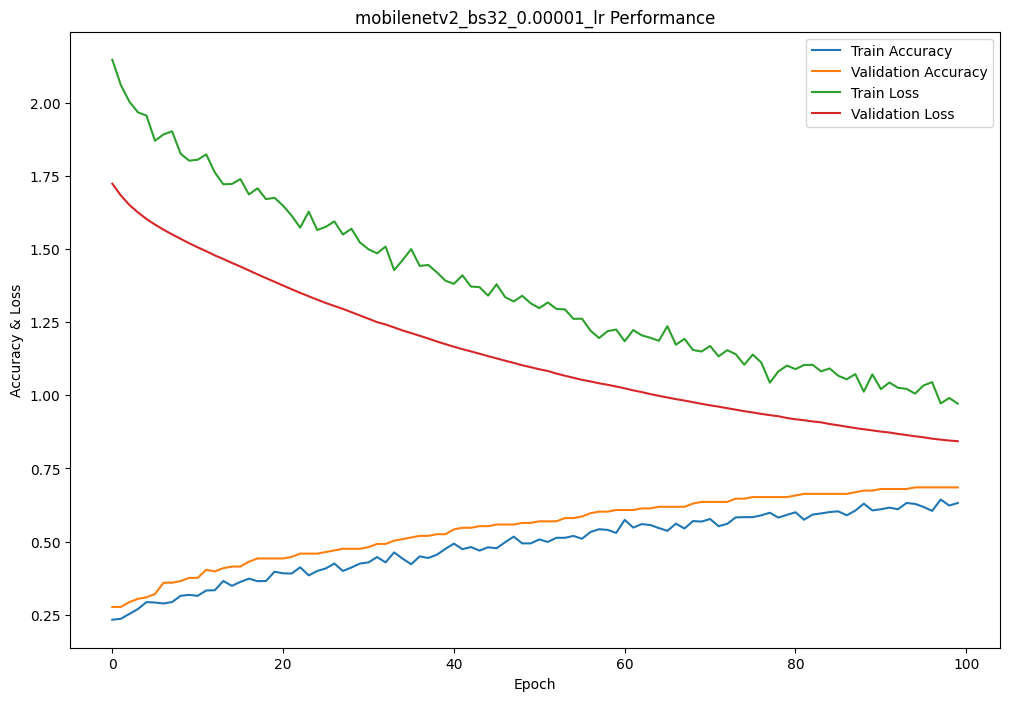


--- mobilenetv2_bs32_0.00001_lr Validation Set Evaluation ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 330ms/step

Validation Set Classification Report:

                        precision    recall  f1-score   support

Brinjal Fruit Creaking       0.33      0.05      0.09        20
        Healty Brinjal       0.76      0.75      0.76        52
      Phomopsis Bright       0.50      0.25      0.33        16
 Shoot and Fruit Borer       0.64      0.86      0.74        73
               Wet Rot       0.81      0.85      0.83        20

              accuracy                           0.69       181
             macro avg       0.61      0.55      0.55       181
          weighted avg       0.65      0.69      0.65       181


--- mobilenetv2_bs32_0.00001_lr Final Test Set Evaluation ---
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step

Test Set Classification Report:

                        precision    recall  f1-score   support

Brinjal Fruit Creaking       0.62      0.38      0.47        40
        Heal

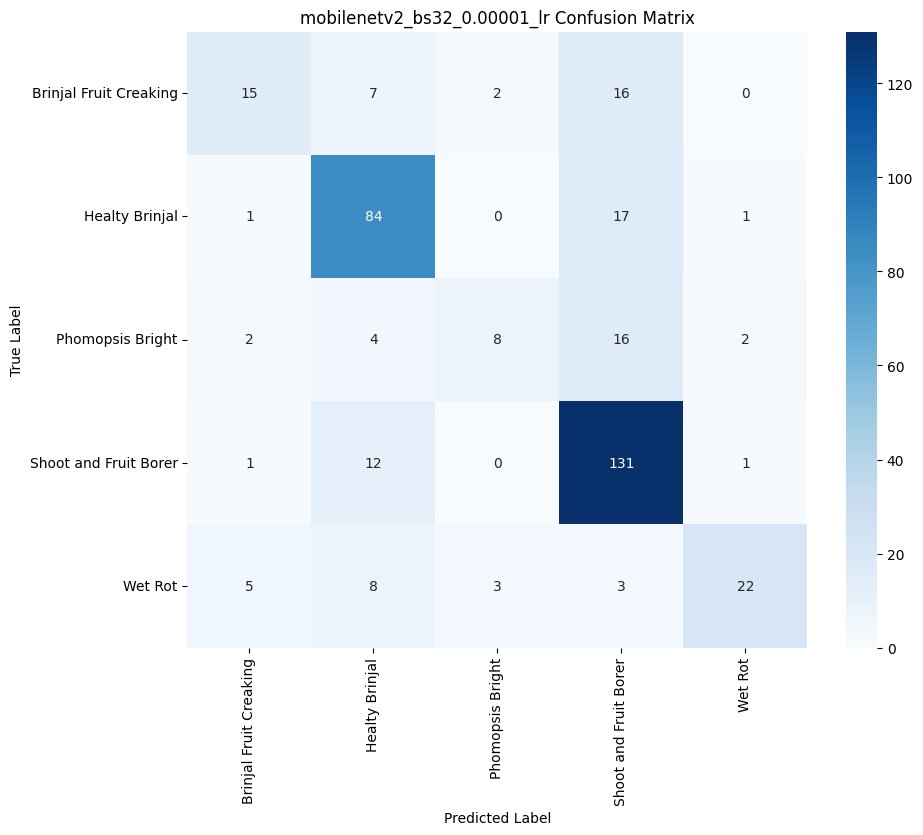


Updating summary results file...
Updated results for mobilenetv2_bs32_0.00001_lr in results\summary_results.csv

The best version of mobilenetv2_bs32_0.00001_lr was saved to 'results\mobilenetv2_bs32_0.00001_lr\best_model.keras'


In [10]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
MODEL_NAME = 'mobilenetv2_bs32_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (MobileNetV2) ---
EPOCHS = 100
BATCH_SIZE = 32

# --- Learning Rate Configuration & Callbacks ---
INITIAL_LR = 0.00001
DECAY_RATE = 0.96
DECAY_STEPS = 1000

PATIENCE = 15

# def lr_scheduler(epoch, lr):
#     return INITIAL_LR * DECAY_RATE**(epoch * (X_train.shape[0] // BATCH_SIZE) / DECAY_STEPS)

early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

# lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)
# callbacks_list = [early_stopping, model_checkpoint, lr_callback]
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
# --- MODIFIED: Merged into a single plot to match the paper's style ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
# --- ADDED: Detailed report for the VALIDATION set ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

# --- Evaluation on the TEST set remains the same ---
print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

# --- Saving the Test Set report and Confusion Matrix ---
report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
# This section remains the same
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

---

Model: EfficientNetB0 

Learning Rate: 0.0001

Batch Size: 8

Max EPOCH = 100

Patience = 15

Time Taken =

Loading preprocessed data...
Data loaded successfully.

Starting efficientnetb0_bs8_0.0001_lr model training...
Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3118 - loss: 1.5488
Epoch 1: val_loss improved from inf to 1.42825, saving model to results\efficientnetb0_bs8_0.0001_lr\best_model.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 25s 111ms/step - accuracy: 0.3121 - loss: 1.5485 - val_accuracy: 0.4033 - val_loss: 1.4282
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.3711 - loss: 1.4351
Epoch 2: val_loss improved from 1.42825 to 1.42738, saving model to results\efficientnetb0_bs8_0.0001_lr\best_model.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - accuracy: 0.3711 - loss: 1.4352 - val_accuracy: 0.4033 - val_loss: 1.4274
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.3875 - loss: 1.4507
Epoch 3: val_loss improved from 1.42738 to 1.42693, saving model to results\efficientnetb0_bs8_0.0001_lr\best_model.keras
158/158 ━━━━━━━━━━━━━━━

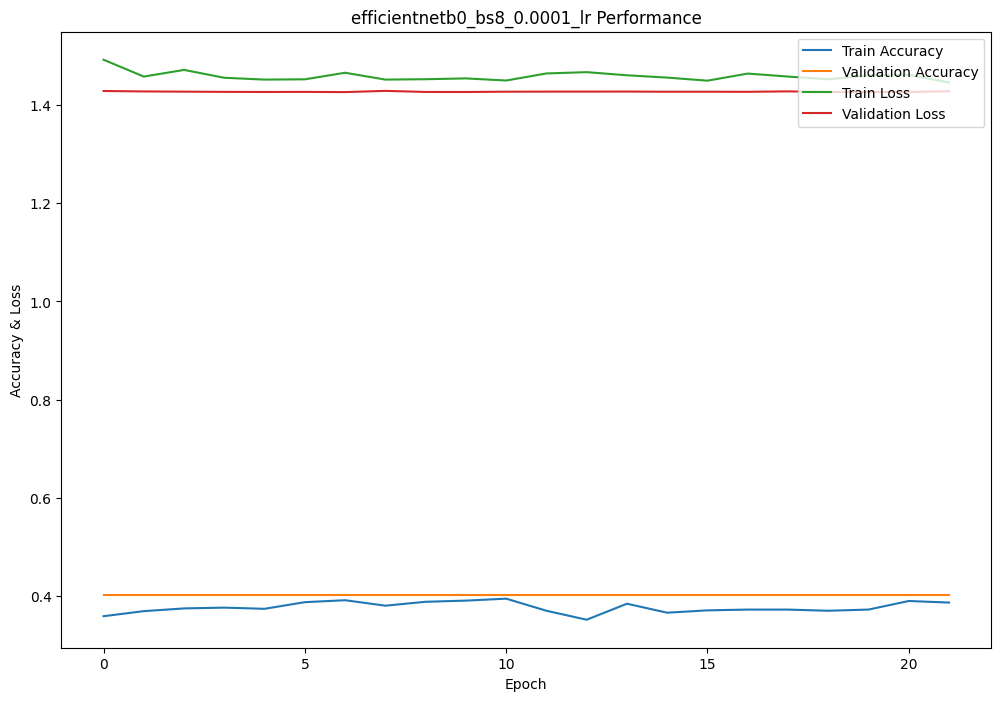


--- efficientnetb0_bs8_0.0001_lr Validation Set Evaluation ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 541ms/step

Validation Set Classification Report:

                        precision    recall  f1-score   support

Brinjal Fruit Creaking       0.00      0.00      0.00        20
        Healty Brinjal       0.00      0.00      0.00        52
      Phomopsis Bright       0.00      0.00      0.00        16
 Shoot and Fruit Borer       0.40      1.00      0.57        73
               Wet Rot       0.00      0.00      0.00        20

              accuracy                           0.40       181
             macro avg       0.08      0.20      0.11       181
          weighted avg       0.16      0.40      0.23       181


--- efficientnetb0_bs8_0.0001_lr Final Test Set Evaluation ---


c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.p

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 209ms/step

Test Set Classification Report:

                        precision    recall  f1-score   support

Brinjal Fruit Creaking       0.00      0.00      0.00        40
        Healty Brinjal       0.00      0.00      0.00       103
      Phomopsis Bright       0.00      0.00      0.00        32
 Shoot and Fruit Borer       0.40      1.00      0.57       145
               Wet Rot       0.00      0.00      0.00        41

              accuracy                           0.40       361
             macro avg       0.08      0.20      0.11       361
          weighted avg       0.16      0.40      0.23       361

Test classification report saved to results\efficientnetb0_bs8_0.0001_lr\classification_report.csv


c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.p

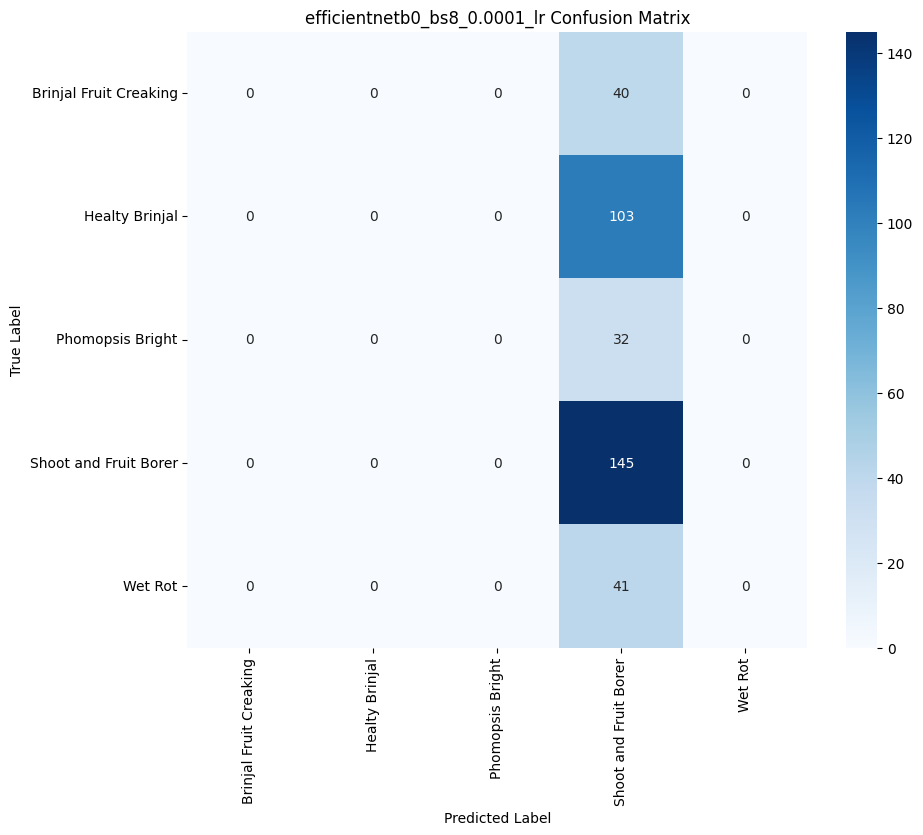


Updating summary results file...
Updated results for efficientnetb0_bs8_0.0001_lr in results\summary_results.csv

The best version of efficientnetb0_bs8_0.0001_lr was saved to 'results\efficientnetb0_bs8_0.0001_lr\best_model.keras'


In [11]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
MODEL_NAME = 'efficientnetb0_bs8_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (EfficientNetB0) ---
EPOCHS = 100
BATCH_SIZE = 8
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
# def lr_scheduler(epoch, lr):
#     return INITIAL_LR * DECAY_RATE**(epoch * (X_train.shape[0] // BATCH_SIZE) / DECAY_STEPS)

early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

# lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)
# callbacks_list = [early_stopping, model_checkpoint, lr_callback]
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: EfficientNetB0 

Learning Rate: 0.00001

Batch Size: 8

Max EPOCH = 100

Patience = 15

Time Taken =

Loading preprocessed data...
Data loaded successfully.

Starting efficientnetb0_bs8_0.00001_lr model training...
Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.2346 - loss: 1.6107
Epoch 1: val_loss improved from inf to 1.51972, saving model to results\efficientnetb0_bs8_0.00001_lr\best_model.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 24s 108ms/step - accuracy: 0.2348 - loss: 1.6105 - val_accuracy: 0.4033 - val_loss: 1.5197
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.3419 - loss: 1.5349
Epoch 2: val_loss improved from 1.51972 to 1.47929, saving model to results\efficientnetb0_bs8_0.00001_lr\best_model.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 16s 99ms/step - accuracy: 0.3420 - loss: 1.5349 - val_accuracy: 0.4033 - val_loss: 1.4793
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.3726 - loss: 1.4805
Epoch 3: val_loss improved from 1.47929 to 1.45577, saving model to results\efficientnetb0_bs8_0.00001_lr\best_model.keras
158/158 ━━━━━━━━━━━

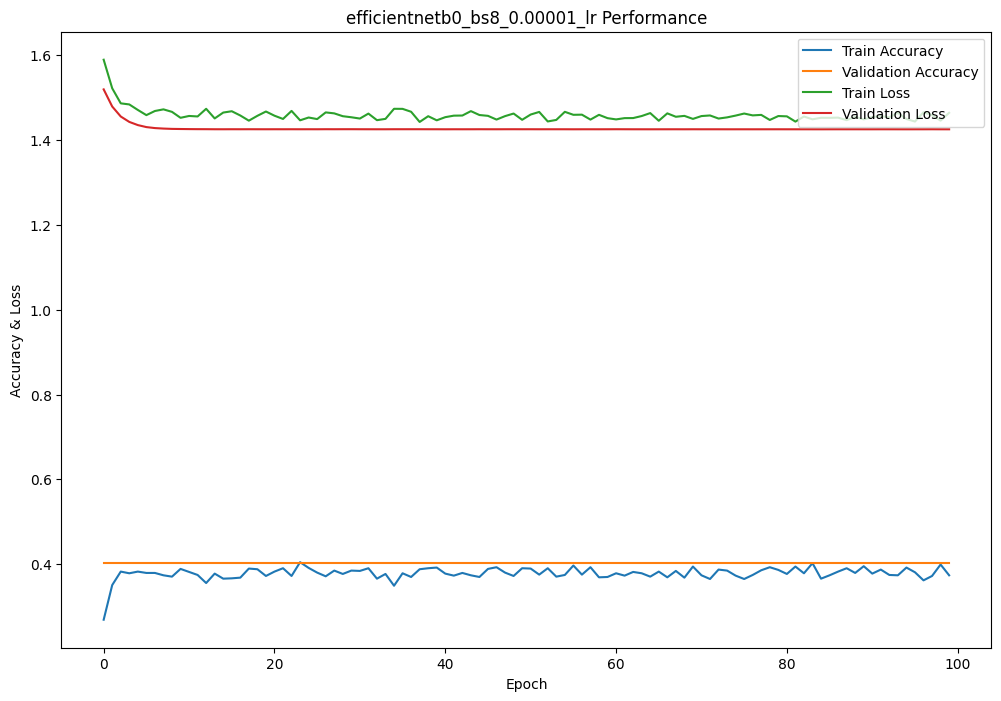


--- efficientnetb0_bs8_0.00001_lr Validation Set Evaluation ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 530ms/step

Validation Set Classification Report:

                        precision    recall  f1-score   support

Brinjal Fruit Creaking       0.00      0.00      0.00        20
        Healty Brinjal       0.00      0.00      0.00        52
      Phomopsis Bright       0.00      0.00      0.00        16
 Shoot and Fruit Borer       0.40      1.00      0.57        73
               Wet Rot       0.00      0.00      0.00        20

              accuracy                           0.40       181
             macro avg       0.08      0.20      0.11       181
          weighted avg       0.16      0.40      0.23       181


--- efficientnetb0_bs8_0.00001_lr Final Test Set Evaluation ---


c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.p

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 212ms/step

Test Set Classification Report:

                        precision    recall  f1-score   support

Brinjal Fruit Creaking       0.00      0.00      0.00        40
        Healty Brinjal       0.00      0.00      0.00       103
      Phomopsis Bright       0.00      0.00      0.00        32
 Shoot and Fruit Borer       0.40      1.00      0.57       145
               Wet Rot       0.00      0.00      0.00        41

              accuracy                           0.40       361
             macro avg       0.08      0.20      0.11       361
          weighted avg       0.16      0.40      0.23       361

Test classification report saved to results\efficientnetb0_bs8_0.00001_lr\classification_report.csv


c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.p

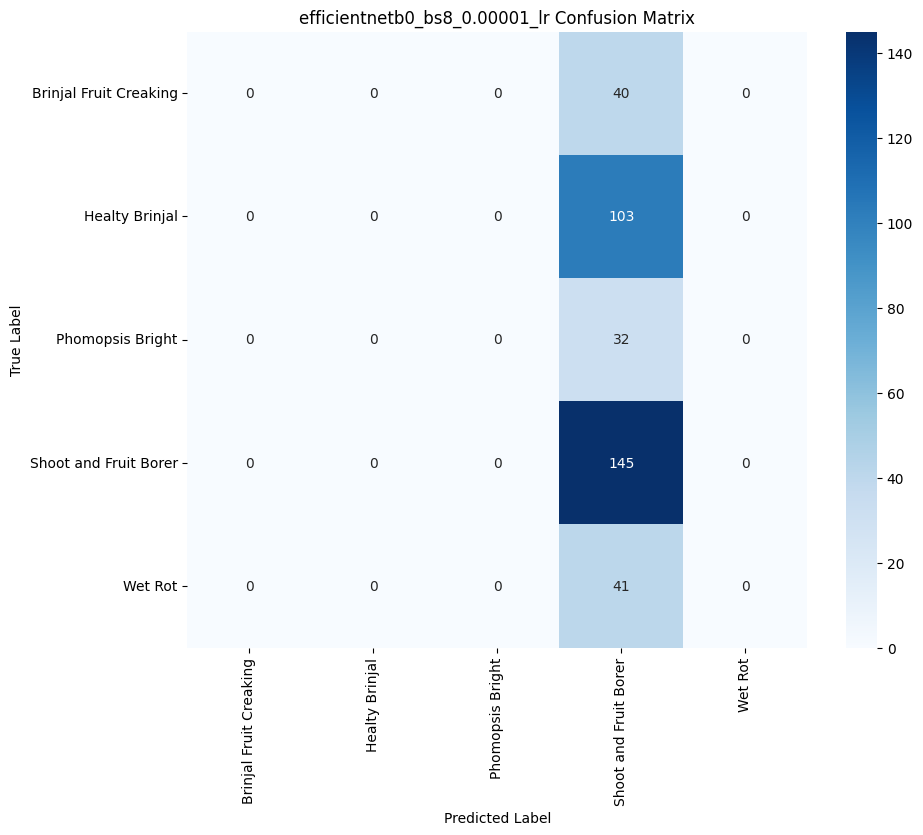


Updating summary results file...
Updated results for efficientnetb0_bs8_0.00001_lr in results\summary_results.csv

The best version of efficientnetb0_bs8_0.00001_lr was saved to 'results\efficientnetb0_bs8_0.00001_lr\best_model.keras'


In [12]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
MODEL_NAME = 'efficientnetb0_bs8_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (EfficientNetB0) ---
EPOCHS = 100
BATCH_SIZE = 8
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
# def lr_scheduler(epoch, lr):
#     return INITIAL_LR * DECAY_RATE**(epoch * (X_train.shape[0] // BATCH_SIZE) / DECAY_STEPS)

early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

# lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)
# callbacks_list = [early_stopping, model_checkpoint, lr_callback]
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: EfficientNetB0 

Learning Rate: 0.0001

Batch Size: 16

Max EPOCH = 100

Patience = 15

Time Taken =

Loading preprocessed data...
Data loaded successfully.

Starting efficientnetb0_bs16_0.0001_lr model training...
Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.3215 - loss: 1.5157
Epoch 1: val_loss improved from inf to 1.42665, saving model to results\efficientnetb0_bs16_0.0001_lr\best_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 190ms/step - accuracy: 0.3220 - loss: 1.5153 - val_accuracy: 0.4033 - val_loss: 1.4267
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.3689 - loss: 1.4684
Epoch 2: val_loss improved from 1.42665 to 1.42585, saving model to results\efficientnetb0_bs16_0.0001_lr\best_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 164ms/step - accuracy: 0.3689 - loss: 1.4684 - val_accuracy: 0.4033 - val_loss: 1.4259
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.3757 - loss: 1.4826
Epoch 3: val_loss improved from 1.42585 to 1.42573, saving model to results\efficientnetb0_bs16_0.0001_lr\best_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━

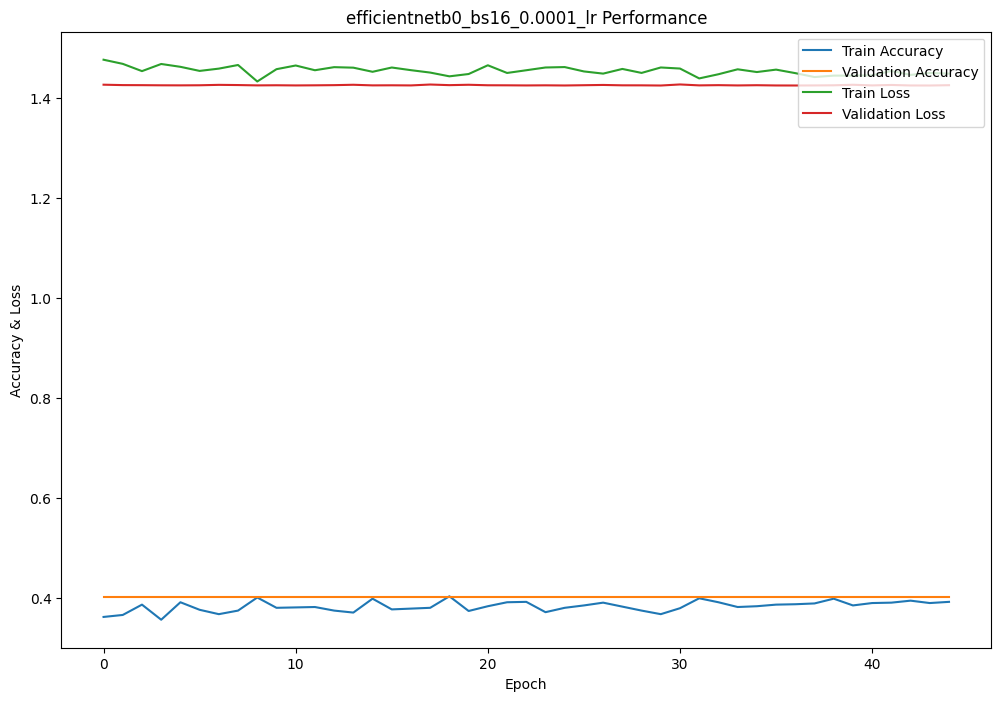


--- efficientnetb0_bs16_0.0001_lr Validation Set Evaluation ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 531ms/step

Validation Set Classification Report:

                        precision    recall  f1-score   support

Brinjal Fruit Creaking       0.00      0.00      0.00        20
        Healty Brinjal       0.00      0.00      0.00        52
      Phomopsis Bright       0.00      0.00      0.00        16
 Shoot and Fruit Borer       0.40      1.00      0.57        73
               Wet Rot       0.00      0.00      0.00        20

              accuracy                           0.40       181
             macro avg       0.08      0.20      0.11       181
          weighted avg       0.16      0.40      0.23       181


--- efficientnetb0_bs16_0.0001_lr Final Test Set Evaluation ---


c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.p

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 210ms/step

Test Set Classification Report:

                        precision    recall  f1-score   support

Brinjal Fruit Creaking       0.00      0.00      0.00        40
        Healty Brinjal       0.00      0.00      0.00       103
      Phomopsis Bright       0.00      0.00      0.00        32
 Shoot and Fruit Borer       0.40      1.00      0.57       145
               Wet Rot       0.00      0.00      0.00        41

              accuracy                           0.40       361
             macro avg       0.08      0.20      0.11       361
          weighted avg       0.16      0.40      0.23       361

Test classification report saved to results\efficientnetb0_bs16_0.0001_lr\classification_report.csv


c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.p

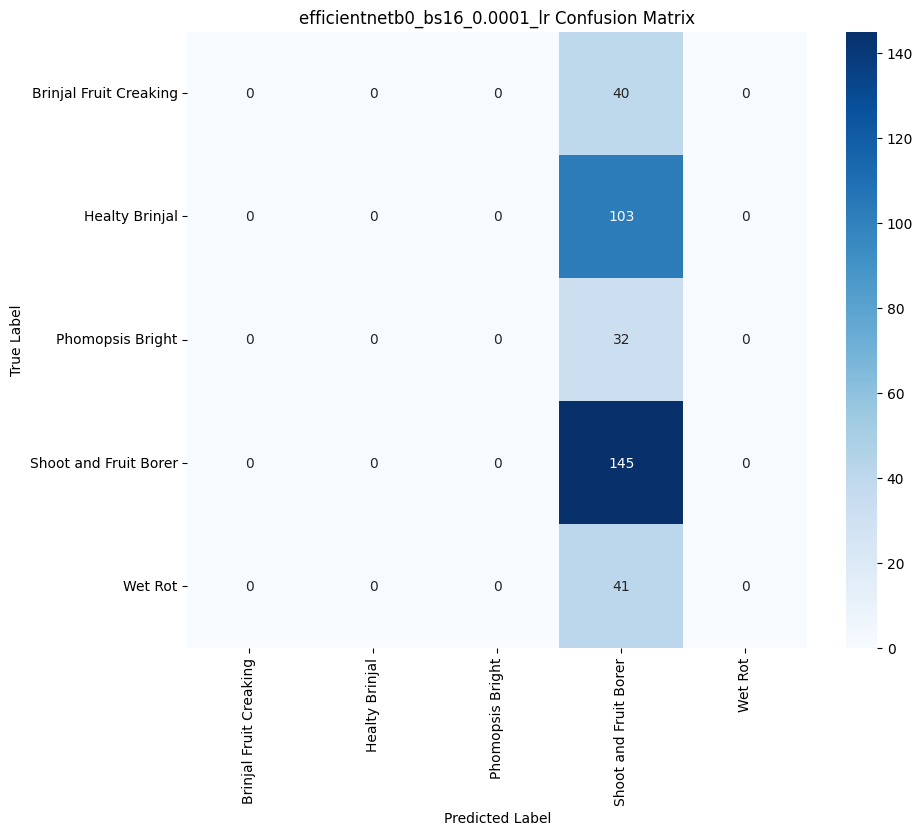


Updating summary results file...
Updated results for efficientnetb0_bs16_0.0001_lr in results\summary_results.csv

The best version of efficientnetb0_bs16_0.0001_lr was saved to 'results\efficientnetb0_bs16_0.0001_lr\best_model.keras'


In [13]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
MODEL_NAME = 'efficientnetb0_bs16_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (EfficientNetB0) ---
EPOCHS = 100
BATCH_SIZE = 16
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
# def lr_scheduler(epoch, lr):
#     return INITIAL_LR * DECAY_RATE**(epoch * (X_train.shape[0] // BATCH_SIZE) / DECAY_STEPS)

early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

# lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)
# callbacks_list = [early_stopping, model_checkpoint, lr_callback]
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: EfficientNetB0 

Learning Rate: 0.00001

Batch Size: 16

Max EPOCH = 100

Patience = 15

Time Taken =

Loading preprocessed data...
Data loaded successfully.

Starting efficientnetb0_bs16_0.00001_lr model training...
Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.1249 - loss: 1.7877
Epoch 1: val_loss improved from inf to 1.67586, saving model to results\efficientnetb0_bs16_0.00001_lr\best_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 22s 195ms/step - accuracy: 0.1251 - loss: 1.7873 - val_accuracy: 0.1105 - val_loss: 1.6759
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.1711 - loss: 1.6807
Epoch 2: val_loss improved from 1.67586 to 1.60981, saving model to results\efficientnetb0_bs16_0.00001_lr\best_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 164ms/step - accuracy: 0.1711 - loss: 1.6804 - val_accuracy: 0.1105 - val_loss: 1.6098
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.2620 - loss: 1.6154
Epoch 3: val_loss improved from 1.60981 to 1.55773, saving model to results\efficientnetb0_bs16_0.00001_lr\best_model.keras
79/79 ━━━━━━━━━━━━━━━

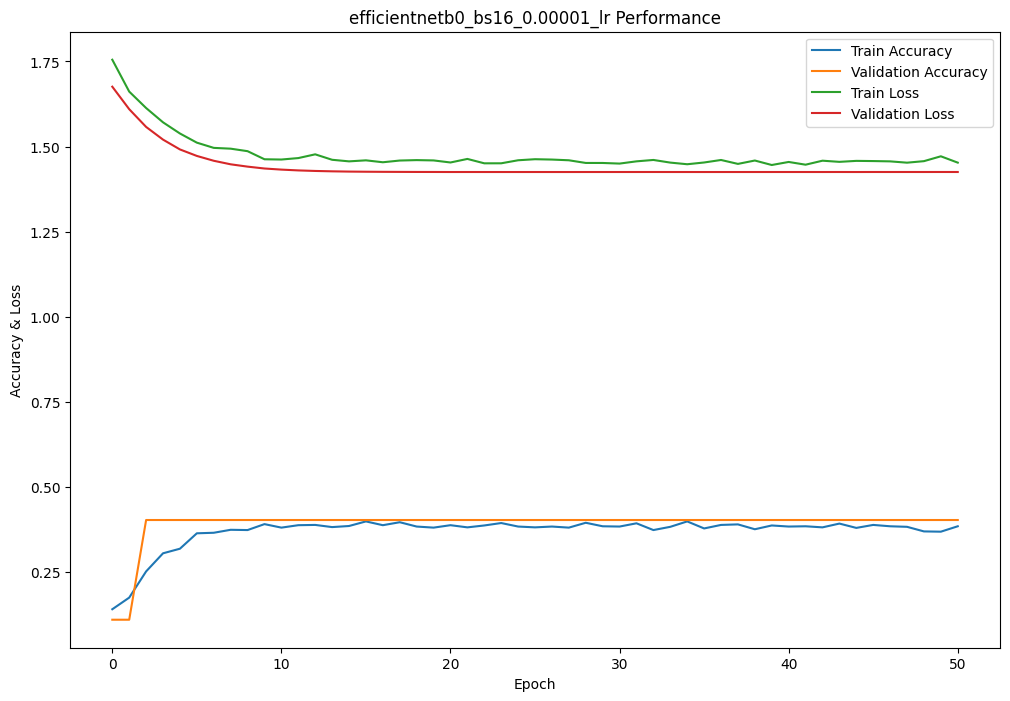


--- efficientnetb0_bs16_0.00001_lr Validation Set Evaluation ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 537ms/step

Validation Set Classification Report:

                        precision    recall  f1-score   support

Brinjal Fruit Creaking       0.00      0.00      0.00        20
        Healty Brinjal       0.00      0.00      0.00        52
      Phomopsis Bright       0.00      0.00      0.00        16
 Shoot and Fruit Borer       0.40      1.00      0.57        73
               Wet Rot       0.00      0.00      0.00        20

              accuracy                           0.40       181
             macro avg       0.08      0.20      0.11       181
          weighted avg       0.16      0.40      0.23       181


--- efficientnetb0_bs16_0.00001_lr Final Test Set Evaluation ---


c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.p

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step

Test Set Classification Report:

                        precision    recall  f1-score   support

Brinjal Fruit Creaking       0.00      0.00      0.00        40
        Healty Brinjal       0.00      0.00      0.00       103
      Phomopsis Bright       0.00      0.00      0.00        32
 Shoot and Fruit Borer       0.40      1.00      0.57       145
               Wet Rot       0.00      0.00      0.00        41

              accuracy                           0.40       361
             macro avg       0.08      0.20      0.11       361
          weighted avg       0.16      0.40      0.23       361

Test classification report saved to results\efficientnetb0_bs16_0.00001_lr\classification_report.csv


c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.p

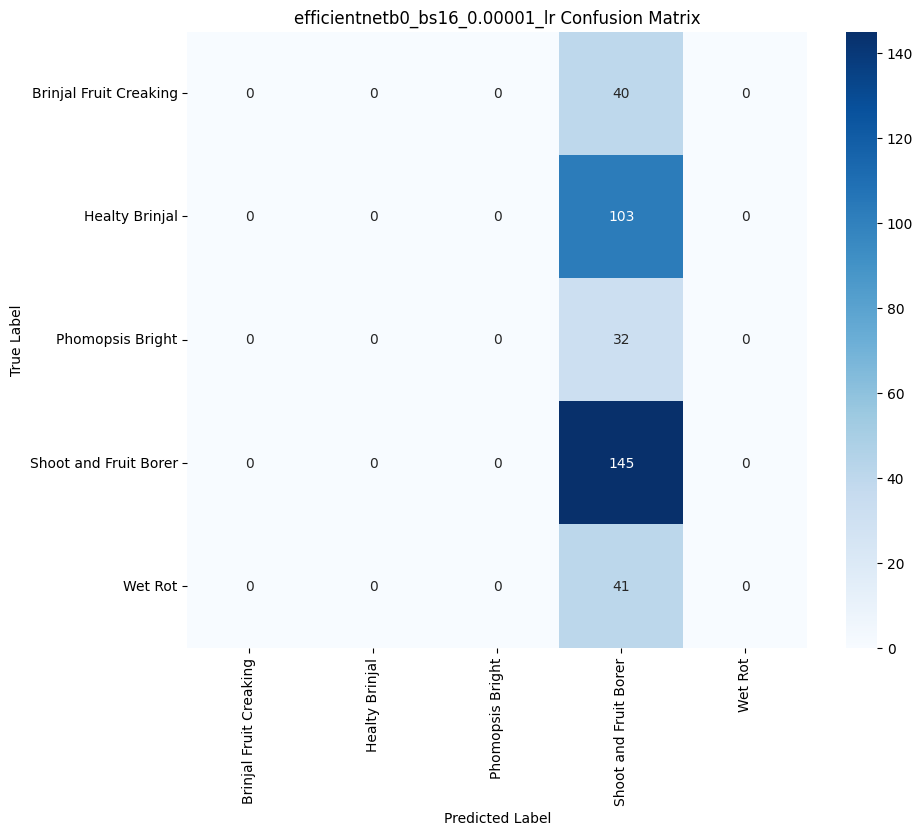


Updating summary results file...
Updated results for efficientnetb0_bs16_0.00001_lr in results\summary_results.csv

The best version of efficientnetb0_bs16_0.00001_lr was saved to 'results\efficientnetb0_bs16_0.00001_lr\best_model.keras'


In [14]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
MODEL_NAME = 'efficientnetb0_bs16_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (EfficientNetB0) ---
EPOCHS = 100
BATCH_SIZE = 16
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
# def lr_scheduler(epoch, lr):
#     return INITIAL_LR * DECAY_RATE**(epoch * (X_train.shape[0] // BATCH_SIZE) / DECAY_STEPS)

early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

# lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)
# callbacks_list = [early_stopping, model_checkpoint, lr_callback]
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: EfficientNetB0 

Learning Rate: 0.0001

Batch Size: 32

Max EPOCH = 100

Patience = 15

Time Taken =

Loading preprocessed data...
Data loaded successfully.

Starting efficientnetb0_bs32_0.0001_lr model training...
Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.2681 - loss: 1.5666
Epoch 1: val_loss improved from inf to 1.43528, saving model to results\efficientnetb0_bs32_0.0001_lr\best_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 355ms/step - accuracy: 0.2693 - loss: 1.5655 - val_accuracy: 0.4033 - val_loss: 1.4353
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.3716 - loss: 1.4545
Epoch 2: val_loss improved from 1.43528 to 1.42592, saving model to results\efficientnetb0_bs32_0.0001_lr\best_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 288ms/step - accuracy: 0.3715 - loss: 1.4548 - val_accuracy: 0.4033 - val_loss: 1.4259
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.3905 - loss: 1.4534
Epoch 3: val_loss improved from 1.42592 to 1.42591, saving model to results\efficientnetb0_bs32_0.0001_lr\best_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━

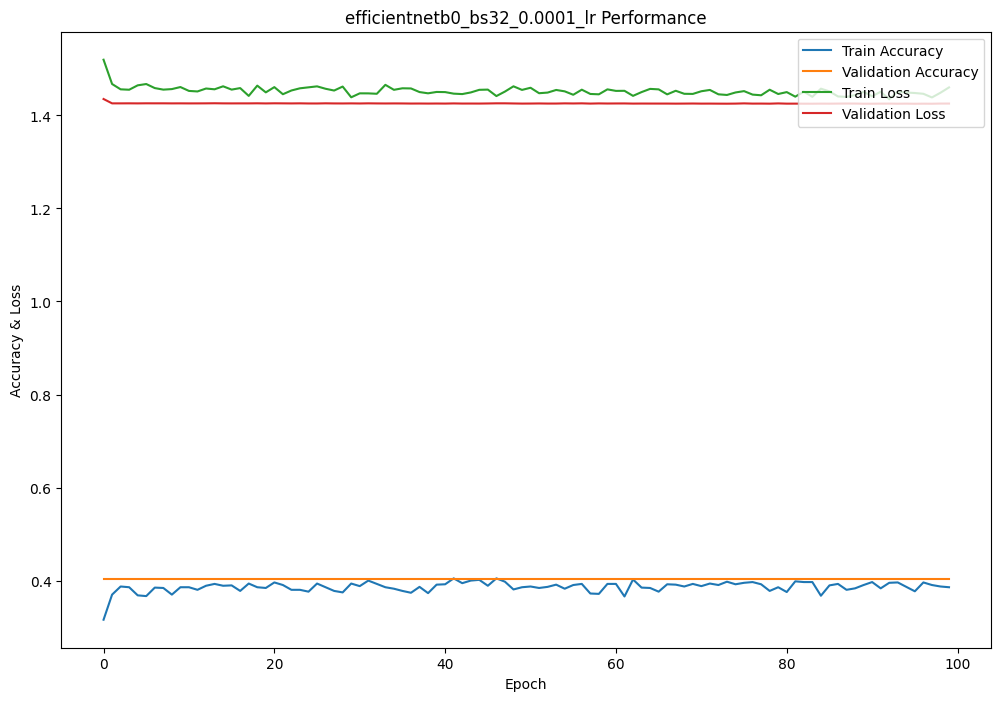


--- efficientnetb0_bs32_0.0001_lr Validation Set Evaluation ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 556ms/step

Validation Set Classification Report:

                        precision    recall  f1-score   support

Brinjal Fruit Creaking       0.00      0.00      0.00        20
        Healty Brinjal       0.00      0.00      0.00        52
      Phomopsis Bright       0.00      0.00      0.00        16
 Shoot and Fruit Borer       0.40      1.00      0.57        73
               Wet Rot       0.00      0.00      0.00        20

              accuracy                           0.40       181
             macro avg       0.08      0.20      0.11       181
          weighted avg       0.16      0.40      0.23       181


--- efficientnetb0_bs32_0.0001_lr Final Test Set Evaluation ---


c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.p

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step

Test Set Classification Report:

                        precision    recall  f1-score   support

Brinjal Fruit Creaking       0.00      0.00      0.00        40
        Healty Brinjal       0.00      0.00      0.00       103
      Phomopsis Bright       0.00      0.00      0.00        32
 Shoot and Fruit Borer       0.40      1.00      0.57       145
               Wet Rot       0.00      0.00      0.00        41

              accuracy                           0.40       361
             macro avg       0.08      0.20      0.11       361
          weighted avg       0.16      0.40      0.23       361

Test classification report saved to results\efficientnetb0_bs32_0.0001_lr\classification_report.csv


c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.p

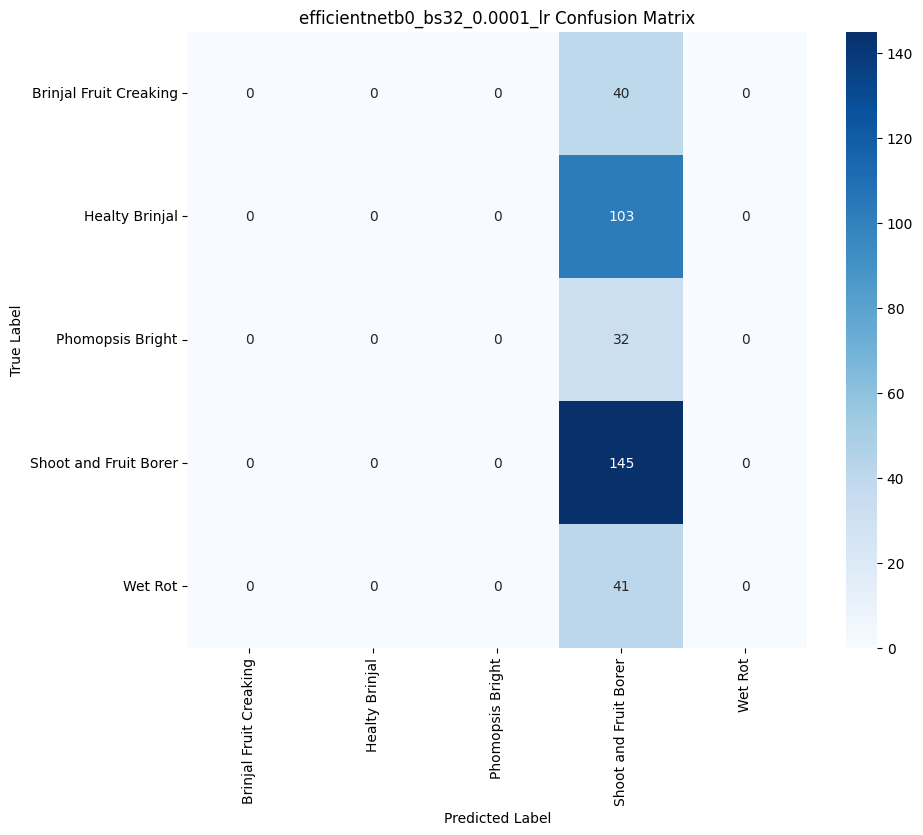


Updating summary results file...
Updated results for efficientnetb0_bs32_0.0001_lr in results\summary_results.csv

The best version of efficientnetb0_bs32_0.0001_lr was saved to 'results\efficientnetb0_bs32_0.0001_lr\best_model.keras'


In [15]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
MODEL_NAME = 'efficientnetb0_bs32_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (EfficientNetB0) ---
EPOCHS = 100
BATCH_SIZE = 32
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
# def lr_scheduler(epoch, lr):
#     return INITIAL_LR * DECAY_RATE**(epoch * (X_train.shape[0] // BATCH_SIZE) / DECAY_STEPS)

early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

# lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)
# callbacks_list = [early_stopping, model_checkpoint, lr_callback]
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: EfficientNetB0 

Learning Rate: 0.00001

Batch Size: 32

Max EPOCH = 100

Patience = 15

Time Taken =

Loading preprocessed data...
Data loaded successfully.

Starting efficientnetb0_bs8_0.0001_lr model training...
Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.2270 - loss: 1.5883
Epoch 1: val_loss improved from inf to 1.53755, saving model to results\efficientnetb0_bs8_0.0001_lr\best_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 351ms/step - accuracy: 0.2274 - loss: 1.5883 - val_accuracy: 0.2873 - val_loss: 1.5375
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.2756 - loss: 1.5624
Epoch 2: val_loss improved from 1.53755 to 1.51575, saving model to results\efficientnetb0_bs8_0.0001_lr\best_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 266ms/step - accuracy: 0.2753 - loss: 1.5625 - val_accuracy: 0.4033 - val_loss: 1.5158
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.3058 - loss: 1.5337
Epoch 3: val_loss improved from 1.51575 to 1.49830, saving model to results\efficientnetb0_bs8_0.0001_lr\best_model.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 11

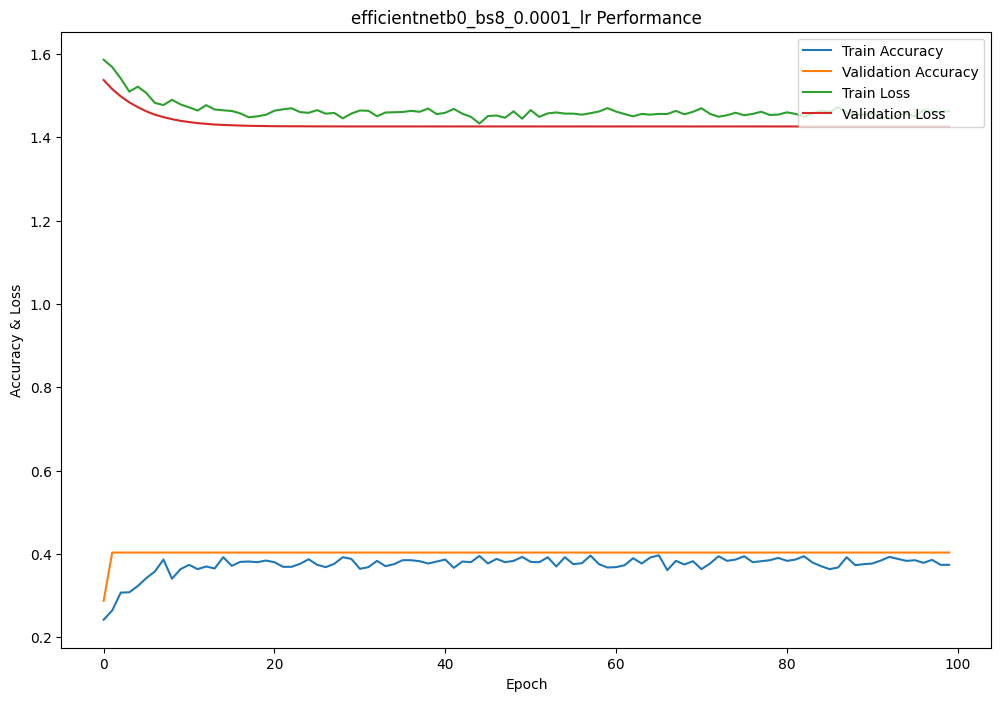


--- efficientnetb0_bs8_0.0001_lr Validation Set Evaluation ---
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 710ms/step

Validation Set Classification Report:

                        precision    recall  f1-score   support

Brinjal Fruit Creaking       0.00      0.00      0.00        20
        Healty Brinjal       0.00      0.00      0.00        52
      Phomopsis Bright       0.00      0.00      0.00        16
 Shoot and Fruit Borer       0.40      1.00      0.57        73
               Wet Rot       0.00      0.00      0.00        20

              accuracy                           0.40       181
             macro avg       0.08      0.20      0.11       181
          weighted avg       0.16      0.40      0.23       181


--- efficientnetb0_bs8_0.0001_lr Final Test Set Evaluation ---


c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.p

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step

Test Set Classification Report:

                        precision    recall  f1-score   support

Brinjal Fruit Creaking       0.00      0.00      0.00        40
        Healty Brinjal       0.00      0.00      0.00       103
      Phomopsis Bright       0.00      0.00      0.00        32
 Shoot and Fruit Borer       0.40      1.00      0.57       145
               Wet Rot       0.00      0.00      0.00        41

              accuracy                           0.40       361
             macro avg       0.08      0.20      0.11       361
          weighted avg       0.16      0.40      0.23       361

Test classification report saved to results\efficientnetb0_bs8_0.0001_lr\classification_report.csv


c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\dr-basab\Desktop\Research Projects\A-Deep-Learning-Model-Optimization-for-Diverse-Classification-Tasks\venv\Lib\site-packages\sklearn\metrics\_classification.p

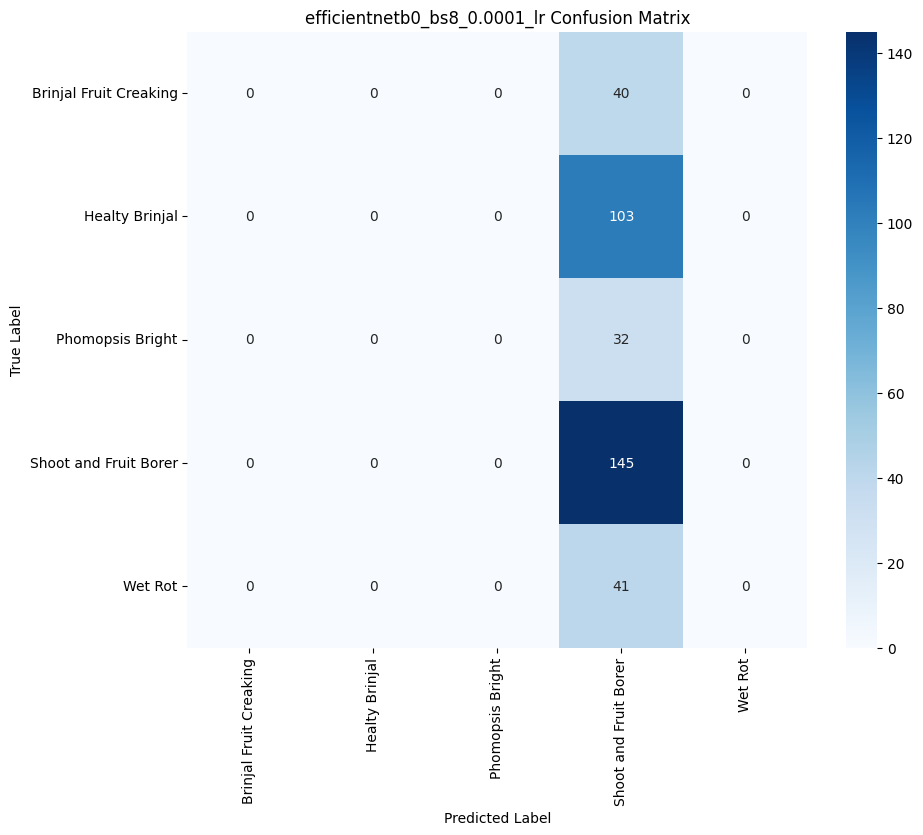


Updating summary results file...
Updated results for efficientnetb0_bs8_0.0001_lr in results\summary_results.csv

The best version of efficientnetb0_bs8_0.0001_lr was saved to 'results\efficientnetb0_bs8_0.0001_lr\best_model.keras'


C:\Users\dr-basab\AppData\Local\Temp\ipykernel_33756\59964061.py:136: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.4017' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
C:\Users\dr-basab\AppData\Local\Temp\ipykernel_33756\59964061.py:136: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.4301' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
C:\Users\dr-basab\AppData\Local\Temp\ipykernel_33756\59964061.py:136: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1146' has dtype incompatible 

In [16]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
MODEL_NAME = 'efficientnetb0_bs8_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (EfficientNetB0) ---
EPOCHS = 100
BATCH_SIZE = 32
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
# def lr_scheduler(epoch, lr):
#     return INITIAL_LR * DECAY_RATE**(epoch * (X_train.shape[0] // BATCH_SIZE) / DECAY_STEPS)

early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

# lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)
# callbacks_list = [early_stopping, model_checkpoint, lr_callback]
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

---

Creating 299 x 299 image dataset

In [17]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import json

# --- 1. Configuration ---
# Define paths and parameters
RAW_DATA_DIR = os.path.join('raw_data', 'BrinjalFruitX')
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX_299x299')
IMG_SIZE = (299, 299)
TEST_SPLIT_SIZE = 0.20 # 20% for the final test set
VALIDATION_SPLIT_SIZE = 0.125 # 10% of the original data (0.125 * 0.8 = 0.1)
RANDOM_STATE = 42 # For reproducible splits

# --- 2. Create Processed Data Directory ---
# This ensures the folder exists before we try to save files to it.
os.makedirs(PROCESSED_DIR, exist_ok=True)
print(f"Directory '{PROCESSED_DIR}' is ready.")

# --- 3. Load Images and Labels ---
images = []
labels = []

# Get class names from the folder names in the raw data directory
class_names = sorted([d for d in os.listdir(RAW_DATA_DIR) if os.path.isdir(os.path.join(RAW_DATA_DIR, d))])
# Create a mapping from class name to an integer index
label_map = {name: i for i, name in enumerate(class_names)}

print("Starting image loading and preprocessing...")
# Use tqdm for a progress bar
for class_name in tqdm(class_names, desc="Processing classes"):
    class_path = os.path.join(RAW_DATA_DIR, class_name)
    class_label = label_map[class_name]

    for image_file in os.listdir(class_path):
        image_path = os.path.join(class_path, image_file)

        # Read the image
        image = cv2.imread(image_path)

        # Check if the image was loaded correctly
        if image is not None:
            # Convert image from BGR (OpenCV's default) to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # Resize image to the standard size
            image = cv2.resize(image, IMG_SIZE)
            
            images.append(image)
            labels.append(class_label)
        else:
            print(f"Warning: Could not read image {image_path}. Skipping.")

print("Image loading complete.")

# --- 4. Convert to NumPy Arrays and Normalize ---
# Convert lists to NumPy arrays for efficient processing
images_np = np.array(images)
labels_np = np.array(labels)

# Normalize pixel values from the [0, 255] range to the [0.0, 1.0] range
images_np = images_np / 255.0

print(f"Converted to NumPy arrays. Image data shape: {images_np.shape}, Labels shape: {labels_np.shape}")

# --- 5. Split the Data ---
# First split: separate out the 20% test set
X_train_val, X_test, y_train_val, y_test = train_test_split(
    images_np,
    labels_np,
    test_size=TEST_SPLIT_SIZE,
    random_state=RANDOM_STATE,
    stratify=labels_np  # Ensures class distribution is similar across splits
)

# Second split: separate the remaining data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=VALIDATION_SPLIT_SIZE, # 0.125 of the 80% results in 10% of the original data
    random_state=RANDOM_STATE,
    stratify=y_train_val # Stratify again for the validation split
)

print("Data splitting complete:")
print(f"  Training set:   {X_train.shape[0]} samples")
print(f"  Validation set: {X_val.shape[0]} samples")
print(f"  Test set:       {X_test.shape[0]} samples")

# --- 6. Save the Processed Data ---
print("Saving processed data to .npy files...")

np.save(os.path.join(PROCESSED_DIR, 'X_train.npy'), X_train)
np.save(os.path.join(PROCESSED_DIR, 'y_train.npy'), y_train)

np.save(os.path.join(PROCESSED_DIR, 'X_val.npy'), X_val)
np.save(os.path.join(PROCESSED_DIR, 'y_val.npy'), y_val)

np.save(os.path.join(PROCESSED_DIR, 'X_test.npy'), X_test)
np.save(os.path.join(PROCESSED_DIR, 'y_test.npy'), y_test)

# Save the class names/label map for later use in decoding predictions
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'w') as f:
    json.dump(class_names, f)

print("All data has been processed and saved successfully! ✅")

Directory 'processed_data\BrinjalFruitX_299x299' is ready.
Starting image loading and preprocessing...


Processing classes: 100%|██████████| 5/5 [00:51<00:00, 10.25s/it]


Image loading complete.
Converted to NumPy arrays. Image data shape: (1802, 299, 299, 3), Labels shape: (1802,)
Data splitting complete:
  Training set:   1260 samples
  Validation set: 181 samples
  Test set:       361 samples
Saving processed data to .npy files...
All data has been processed and saved successfully! ✅


Model: Inceptionv3

Learning Rate: 0.0001

Batch Size: 8

Max EPOCH = 100

Patience = 15

Time Taken =

In [20]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX_299x299')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'inceptionv3_bs8_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (InceptionV3) ---
EPOCHS = 100
BATCH_SIZE = 8
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
# Note: This will work with your 224x224 images, but 299x299 is recommended for this model.
base_model = InceptionV3(input_shape=(299, 299, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Loading preprocessed data...
Data loaded successfully.

Starting inceptionv3_bs8_0.0001_lr model training...
Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.2750 - loss: 1.6944
Epoch 1: val_loss improved from inf to 1.37816, saving model to results\inceptionv3_bs8_0.0001_lr\best_model.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 37s 201ms/step - accuracy: 0.2754 - loss: 1.6939 - val_accuracy: 0.4254 - val_loss: 1.3782
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.4214 - loss: 1.4437
Epoch 2: val_loss improved from 1.37816 to 1.24300, saving model to results\inceptionv3_bs8_0.0001_lr\best_model.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 28s 177ms/step - accuracy: 0.4214 - loss: 1.4436 - val_accuracy: 0.4751 - val_loss: 1.2430
Epoch 3/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.4923 - loss: 1.2941
Epoch 3: val_loss improved from 1.24300 to 1.14423, saving model to results\inceptionv3_bs8_0.0001_lr\best_model.keras
158/158 ━━━━━━━━━━━━━━━━━━━━ 28

KeyboardInterrupt: 

Model: Inceptionv3

Learning Rate: 0.00001

Batch Size: 8

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX_299x299')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'inceptionv3_bs8_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (InceptionV3) ---
EPOCHS = 100
BATCH_SIZE = 8
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
# Note: This will work with your 224x224 images, but 299x299 is recommended for this model.
base_model = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: Inceptionv3

Learning Rate: 0.0001

Batch Size: 16

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX_299x299')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'inceptionv3_bs16_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (InceptionV3) ---
EPOCHS = 100
BATCH_SIZE = 16
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
# Note: This will work with your 224x224 images, but 299x299 is recommended for this model.
base_model = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: Inceptionv3

Learning Rate: 0.00001

Batch Size: 16

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX_299x299')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'inceptionv3_bs16_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (InceptionV3) ---
EPOCHS = 100
BATCH_SIZE = 16
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
# Note: This will work with your 224x224 images, but 299x299 is recommended for this model.
base_model = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: Inceptionv3

Learning Rate: 0.0001

Batch Size: 32

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX_299x299')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'inceptionv3_bs32_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (InceptionV3) ---
EPOCHS = 100
BATCH_SIZE = 32
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
# Note: This will work with your 224x224 images, but 299x299 is recommended for this model.
base_model = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: Inceptionv3

Learning Rate: 0.00001

Batch Size: 32

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX_299x299')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'inceptionv3_bs32_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (InceptionV3) ---
EPOCHS = 100
BATCH_SIZE = 32
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
# Note: This will work with your 224x224 images, but 299x299 is recommended for this model.
base_model = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

---

Model: VGG16

Learning Rate: 0.0001

Batch Size: 8

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Pointing back to the 224x224 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'vgg16_bs8_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (VGG16) ---
EPOCHS = 100
BATCH_SIZE = 8
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: VGG16

Learning Rate: 0.00001

Batch Size: 8

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Pointing back to the 224x224 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'vgg16_bs8_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (VGG16) ---
EPOCHS = 100
BATCH_SIZE = 8
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: VGG16

Learning Rate: 0.0001

Batch Size: 16

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Pointing back to the 224x224 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'vgg16_bs16_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (VGG16) ---
EPOCHS = 100
BATCH_SIZE = 16
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: VGG16

Learning Rate: 0.00001

Batch Size: 16

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Pointing back to the 224x224 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'vgg16_bs16_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (VGG16) ---
EPOCHS = 100
BATCH_SIZE = 16
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: VGG16

Learning Rate: 0.0001

Batch Size: 32

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Pointing back to the 224x224 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'vgg16_bs32_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (VGG16) ---
EPOCHS = 100
BATCH_SIZE = 32
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: VGG16

Learning Rate: 0.00001

Batch Size: 32

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Pointing back to the 224x224 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'vgg16_bs32_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (VGG16) ---
EPOCHS = 100
BATCH_SIZE = 32
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

---

Model: ResNet50

Learning Rate: 0.0001

Batch Size: 8

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# Using the 224x224 dataset directory
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'resnet50_bs8_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (ResNet50) ---
EPOCHS = 100
BATCH_SIZE = 8
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: ResNet50

Learning Rate: 0.00001

Batch Size: 8

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# Using the 224x224 dataset directory
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'resnet50_bs8_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (ResNet50) ---
EPOCHS = 100
BATCH_SIZE = 8
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: ResNet50

Learning Rate: 0.0001

Batch Size: 16

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# Using the 224x224 dataset directory
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'resnet50_bs16_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (ResNet50) ---
EPOCHS = 100
BATCH_SIZE = 16
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: ResNet50

Learning Rate: 0.00001

Batch Size: 16

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# Using the 224x224 dataset directory
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'resnet50_bs16_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (ResNet50) ---
EPOCHS = 100
BATCH_SIZE = 16
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: ResNet50

Learning Rate: 0.0001

Batch Size: 32

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# Using the 224x224 dataset directory
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'resnet50_bs32_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (ResNet50) ---
EPOCHS = 100
BATCH_SIZE = 32
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: ResNet50

Learning Rate: 0.00001

Batch Size: 32

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# Using the 224x224 dataset directory
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'resnet50_bs32_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (ResNet50) ---
EPOCHS = 100
BATCH_SIZE = 32
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

---

Model: MobileNetV3

Learning Rate: 0.0001

Batch Size: 8

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# Using the 224x224 dataset directory
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'mobilenetv3_large_bs8_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (MobileNetV3) ---
EPOCHS = 100
BATCH_SIZE = 8
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = MobileNetV3Large(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: MobileNetV3

Learning Rate: 0.00001

Batch Size: 8

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# Using the 224x224 dataset directory
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'mobilenetv3_large_bs8_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (MobileNetV3) ---
EPOCHS = 100
BATCH_SIZE = 8
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = MobileNetV3Large(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: MobileNetV3

Learning Rate: 0.0001

Batch Size: 16

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# Using the 224x224 dataset directory
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'mobilenetv3_large_bs16_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (MobileNetV3) ---
EPOCHS = 100
BATCH_SIZE = 16
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = MobileNetV3Large(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: MobileNetV3

Learning Rate: 0.00001

Batch Size: 16

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# Using the 224x224 dataset directory
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'mobilenetv3_large_bs16_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (MobileNetV3) ---
EPOCHS = 100
BATCH_SIZE = 16
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = MobileNetV3Large(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: MobileNetV3

Learning Rate: 0.0001

Batch Size: 32

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# Using the 224x224 dataset directory
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'mobilenetv3_large_bs32_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (MobileNetV3) ---
EPOCHS = 100
BATCH_SIZE = 32
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = MobileNetV3Large(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: MobileNetV3

Learning Rate: 0.00001

Batch Size: 32

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# Using the 224x224 dataset directory
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'mobilenetv3_large_bs32_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (MobileNetV3) ---
EPOCHS = 100
BATCH_SIZE = 32
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = MobileNetV3Large(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

---

Creating data for EfficientNetB7 on 600 x 600

In [ ]:
import os

import cv2

import numpy as np

from sklearn.model_selection import train_test_split

from tqdm import tqdm

import json



# --- 1. Configuration ---

# Define paths and parameters

RAW_DATA_DIR = os.path.join('raw_data', 'BrinjalFruitX')

PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX_600x600')

IMG_SIZE = (600, 600)

TEST_SPLIT_SIZE = 0.20 # 20% for the final test set

VALIDATION_SPLIT_SIZE = 0.125 # 10% of the original data (0.125 * 0.8 = 0.1)

RANDOM_STATE = 42 # For reproducible splits



# --- 2. Create Processed Data Directory ---

# This ensures the folder exists before we try to save files to it.

os.makedirs(PROCESSED_DIR, exist_ok=True)

print(f"Directory '{PROCESSED_DIR}' is ready.")



# --- 3. Load Images and Labels ---

images = []

labels = []



# Get class names from the folder names in the raw data directory

class_names = sorted([d for d in os.listdir(RAW_DATA_DIR) if os.path.isdir(os.path.join(RAW_DATA_DIR, d))])

# Create a mapping from class name to an integer index

label_map = {name: i for i, name in enumerate(class_names)}



print("Starting image loading and preprocessing...")

# Use tqdm for a progress bar

for class_name in tqdm(class_names, desc="Processing classes"):

    class_path = os.path.join(RAW_DATA_DIR, class_name)

    class_label = label_map[class_name]



    for image_file in os.listdir(class_path):

        image_path = os.path.join(class_path, image_file)



        # Read the image

        image = cv2.imread(image_path)



        # Check if the image was loaded correctly

        if image is not None:

            # Convert image from BGR (OpenCV's default) to RGB

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Resize image to the standard size

            image = cv2.resize(image, IMG_SIZE)

            

            images.append(image)

            labels.append(class_label)

        else:

            print(f"Warning: Could not read image {image_path}. Skipping.")



print("Image loading complete.")



# --- 4. Convert to NumPy Arrays and Normalize ---

# Convert lists to NumPy arrays for efficient processing

images_np = np.array(images)

labels_np = np.array(labels)



# Normalize pixel values from the [0, 255] range to the [0.0, 1.0] range

images_np = images_np / 255.0



print(f"Converted to NumPy arrays. Image data shape: {images_np.shape}, Labels shape: {labels_np.shape}")



# --- 5. Split the Data ---

# First split: separate out the 20% test set

X_train_val, X_test, y_train_val, y_test = train_test_split(

    images_np,

    labels_np,

    test_size=TEST_SPLIT_SIZE,

    random_state=RANDOM_STATE,

    stratify=labels_np  # Ensures class distribution is similar across splits

)



# Second split: separate the remaining data into training and validation sets

X_train, X_val, y_train, y_val = train_test_split(

    X_train_val,

    y_train_val,

    test_size=VALIDATION_SPLIT_SIZE, # 0.125 of the 80% results in 10% of the original data

    random_state=RANDOM_STATE,

    stratify=y_train_val # Stratify again for the validation split

)



print("Data splitting complete:")

print(f"  Training set:   {X_train.shape[0]} samples")

print(f"  Validation set: {X_val.shape[0]} samples")

print(f"  Test set:       {X_test.shape[0]} samples")



# --- 6. Save the Processed Data ---

print("Saving processed data to .npy files...")



np.save(os.path.join(PROCESSED_DIR, 'X_train.npy'), X_train)

np.save(os.path.join(PROCESSED_DIR, 'y_train.npy'), y_train)



np.save(os.path.join(PROCESSED_DIR, 'X_val.npy'), X_val)

np.save(os.path.join(PROCESSED_DIR, 'y_val.npy'), y_val)



np.save(os.path.join(PROCESSED_DIR, 'X_test.npy'), X_test)

np.save(os.path.join(PROCESSED_DIR, 'y_test.npy'), y_test)



# Save the class names/label map for later use in decoding predictions

with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'w') as f:

    json.dump(class_names, f)



print("All data has been processed and saved successfully! ✅")



Model: EfficientNetB7

Learning Rate: 0.0001

Batch Size: 8

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Using the largest available dataset (299x299). 600x600 is recommended for B7.
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX_600x600')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'efficientnetb7_bs8_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (EfficientNetB7) ---
EPOCHS = 100
BATCH_SIZE = 8
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
# Note: Using 299x299 input. For best results, re-process your data to 600x600 for this model.
base_model = EfficientNetB7(input_shape=(299, 299, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: EfficientNetB7

Learning Rate: 0.00001

Batch Size: 8

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Using the largest available dataset (299x299). 600x600 is recommended for B7.
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX_600x600')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'efficientnetb7_bs8_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (EfficientNetB7) ---
EPOCHS = 100
BATCH_SIZE = 8
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
# Note: Using 299x299 input. For best results, re-process your data to 600x600 for this model.
base_model = EfficientNetB7(input_shape=(299, 299, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: EfficientNetB7

Learning Rate: 0.0001

Batch Size: 16

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Using the largest available dataset (299x299). 600x600 is recommended for B7.
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX_600x600')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'efficientnetb7_bs16_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (EfficientNetB7) ---
EPOCHS = 100
BATCH_SIZE = 16
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
# Note: Using 299x299 input. For best results, re-process your data to 600x600 for this model.
base_model = EfficientNetB7(input_shape=(299, 299, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: EfficientNetB7

Learning Rate: 0.00001

Batch Size: 16

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Using the largest available dataset (299x299). 600x600 is recommended for B7.
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX_600x600')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'efficientnetb7_bs16_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (EfficientNetB7) ---
EPOCHS = 100
BATCH_SIZE = 16
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
# Note: Using 299x299 input. For best results, re-process your data to 600x600 for this model.
base_model = EfficientNetB7(input_shape=(299, 299, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: EfficientNetB7

Learning Rate: 0.0001

Batch Size: 32

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Using the largest available dataset (299x299). 600x600 is recommended for B7.
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX_600x600')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'efficientnetb7_bs32_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (EfficientNetB7) ---
EPOCHS = 100
BATCH_SIZE = 32
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
# Note: Using 299x299 input. For best results, re-process your data to 600x600 for this model.
base_model = EfficientNetB7(input_shape=(299, 299, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: EfficientNetB7

Learning Rate: 0.00001

Batch Size: 32

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Using the largest available dataset (299x299). 600x600 is recommended for B7.
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX_600x600')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'efficientnetb7_bs32_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (EfficientNetB7) ---
EPOCHS = 100
BATCH_SIZE = 32
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
# Note: Using 299x299 input. For best results, re-process your data to 600x600 for this model.
base_model = EfficientNetB7(input_shape=(299, 299, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

---

Model: InceptionResNetV2

Learning Rate: 0.0001

Batch Size: 8

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Using the 299x299 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX_299x299')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'inception_resnet_v2_bs8_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (InceptionResNetV2) ---
EPOCHS = 100
BATCH_SIZE = 8
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = InceptionResNetV2(input_shape=(299, 299, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: InceptionResNetV2

Learning Rate: 0.00001

Batch Size: 8

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Using the 299x299 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX_299x299')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'inception_resnet_v2_bs8_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (InceptionResNetV2) ---
EPOCHS = 100
BATCH_SIZE = 8
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = InceptionResNetV2(input_shape=(299, 299, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: InceptionResNetV2

Learning Rate: 0.0001

Batch Size: 16

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Using the 299x299 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX_299x299')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'inception_resnet_v2_bs16_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (InceptionResNetV2) ---
EPOCHS = 100
BATCH_SIZE = 16
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = InceptionResNetV2(input_shape=(299, 299, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: InceptionResNetV2

Learning Rate: 0.00001

Batch Size: 16

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Using the 299x299 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX_299x299')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'inception_resnet_v2_bs16_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (InceptionResNetV2) ---
EPOCHS = 100
BATCH_SIZE = 16
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = InceptionResNetV2(input_shape=(299, 299, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: InceptionResNetV2

Learning Rate: 0.0001

Batch Size: 32

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Using the 299x299 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX_299x299')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'inception_resnet_v2_bs32_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (InceptionResNetV2) ---
EPOCHS = 100
BATCH_SIZE = 32
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = InceptionResNetV2(input_shape=(299, 299, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: InceptionResNetV2

Learning Rate: 0.00001

Batch Size: 32

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Using the 299x299 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX_299x299')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'inception_resnet_v2_bs32_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (InceptionResNetV2) ---
EPOCHS = 100
BATCH_SIZE = 32
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = InceptionResNetV2(input_shape=(299, 299, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

---

Model: VGG19

Learning Rate: 0.0001

Batch Size: 8

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Pointing back to the 224x224 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'vgg19_bs8_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (VGG19) ---
EPOCHS = 100
BATCH_SIZE = 8
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = VGG19(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME}: Model Accuracy & Loss')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: VGG19

Learning Rate: 0.00001

Batch Size: 8

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Pointing back to the 224x224 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'vgg19_bs8_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (VGG19) ---
EPOCHS = 100
BATCH_SIZE = 8
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = VGG19(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME}: Model Accuracy & Loss')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: VGG19

Learning Rate: 0.0001

Batch Size: 16

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Pointing back to the 224x224 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'vgg19_bs16_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (VGG19) ---
EPOCHS = 100
BATCH_SIZE = 16
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = VGG19(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME}: Model Accuracy & Loss')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: VGG19

Learning Rate: 0.00001

Batch Size: 16

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Pointing back to the 224x224 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'vgg19_bs16_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (VGG19) ---
EPOCHS = 100
BATCH_SIZE = 16
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = VGG19(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME}: Model Accuracy & Loss')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: VGG19

Learning Rate: 0.0001

Batch Size: 32

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Pointing back to the 224x224 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'vgg19_bs32_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (VGG19) ---
EPOCHS = 100
BATCH_SIZE = 32
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = VGG19(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME}: Model Accuracy & Loss')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: VGG19

Learning Rate: 0.00001

Batch Size: 32

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- MODIFIED: Pointing back to the 224x224 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'vgg19_bs32_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (VGG19) ---
EPOCHS = 100
BATCH_SIZE = 32
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = VGG19(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME}: Model Accuracy & Loss')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

---

Model: ResNet152

Learning Rate: 0.0001

Batch Size: 8

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- Using the 224x224 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'resnet152_bs8_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (ResNet152) ---
EPOCHS = 100
BATCH_SIZE = 8
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = ResNet152(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME}: Model Accuracy & Loss')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: ResNet152

Learning Rate: 0.00001

Batch Size: 8

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- Using the 224x224 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'resnet152_bs8_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (ResNet152) ---
EPOCHS = 100
BATCH_SIZE = 8
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = ResNet152(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME}: Model Accuracy & Loss')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: ResNet152

Learning Rate: 0.0001

Batch Size: 16

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- Using the 224x224 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'resnet152_bs16_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (ResNet152) ---
EPOCHS = 100
BATCH_SIZE = 16
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = ResNet152(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME}: Model Accuracy & Loss')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: ResNet152

Learning Rate: 0.00001

Batch Size: 16

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- Using the 224x224 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'resnet152_bs16_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (ResNet152) ---
EPOCHS = 100
BATCH_SIZE = 16
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = ResNet152(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME}: Model Accuracy & Loss')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: ResNet152

Learning Rate: 0.0001

Batch Size: 32

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- Using the 224x224 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'resnet152_bs32_0.0001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (ResNet152) ---
EPOCHS = 100
BATCH_SIZE = 32
INITIAL_LR = 0.0001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = ResNet152(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME}: Model Accuracy & Loss')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: ResNet152

Learning Rate: 0.00001

Batch Size: 32

Max EPOCH = 100

Patience = 15

Time Taken =

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
# --- MODIFIED ---
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
# --- Using the 224x224 dataset directory ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
# --- MODIFIED ---
MODEL_NAME = 'resnet152_bs32_0.00001_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (ResNet152) ---
EPOCHS = 100
BATCH_SIZE = 32
INITIAL_LR = 0.00001
PATIENCE = 15

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
callbacks_list = [early_stopping, model_checkpoint]

# --- Model Definition ---
# --- MODIFIED ---
base_model = ResNet152(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME}: Model Accuracy & Loss')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")

Model: MobileNetv2

Learning Rate: Adaptive

Batch Size: 8

Max EPOCH = 100

Patience = 15

Time Taken = 

In [ ]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
# --- ADDED for classification report and confusion matrix ---
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. Configuration and Setup ---
PROCESSED_DIR = os.path.join('processed_data', 'BrinjalFruitX')
RESULTS_DIR = 'results'
MODEL_NAME = 'mobilenetv2_bs8_adaptive_lr'

model_results_dir = os.path.join(RESULTS_DIR, MODEL_NAME)
os.makedirs(model_results_dir, exist_ok=True)

print("Loading preprocessed data...")
# --- Data loading ---
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
X_val = np.load(os.path.join(PROCESSED_DIR, 'X_val.npy'))
y_val = np.load(os.path.join(PROCESSED_DIR, 'y_val.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))
with open(os.path.join(PROCESSED_DIR, 'class_names.json'), 'r') as f:
    class_names = json.load(f)
print("Data loaded successfully.")

# --- 2. Define and Train the Model (MobileNetV2) ---
EPOCHS = 100
BATCH_SIZE = 8

# --- Learning Rate Configuration & Callbacks ---
INITIAL_LR = 0.0001
DECAY_RATE = 0.96
DECAY_STEPS = 1000

PATIENCE = 15

def lr_scheduler(epoch, lr):
    return INITIAL_LR * DECAY_RATE**(epoch * (X_train.shape[0] // BATCH_SIZE) / DECAY_STEPS)

early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
checkpoint_path = os.path.join(model_results_dir, 'best_model.keras')
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)
callbacks_list = [early_stopping, model_checkpoint, lr_callback]

# --- Model Definition ---
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"\nStarting {MODEL_NAME} model training...")
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)
print("Model training complete.")


# --- 3. Visualize Performance and Save Figure ---
# --- MODIFIED: Merged into a single plot to match the paper's style ---
print("\nGenerating and saving single performance plot...")
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{MODEL_NAME} Performance')
plt.ylabel('Accuracy & Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(os.path.join(model_results_dir, 'performance_plot.png'))
plt.show()


# --- 4. In-Depth Evaluation and Save Results ---
# --- ADDED: Detailed report for the VALIDATION set ---
print(f"\n--- {MODEL_NAME} Validation Set Evaluation ---")
y_pred_val_probs = model.predict(X_val)
y_pred_val_classes = np.argmax(y_pred_val_probs, axis=1)

print("\nValidation Set Classification Report:\n")
print(classification_report(y_val, y_pred_val_classes, target_names=class_names))

# --- Evaluation on the TEST set remains the same ---
print(f"\n--- {MODEL_NAME} Final Test Set Evaluation ---")
y_pred_test_probs = model.predict(X_test)
y_pred_test_classes = np.argmax(y_pred_test_probs, axis=1)

report_dict = classification_report(y_test, y_pred_test_classes, target_names=class_names, output_dict=True)
print("\nTest Set Classification Report:\n")
print(classification_report(y_test, y_pred_test_classes, target_names=class_names))

# --- Saving the Test Set report and Confusion Matrix ---
report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(os.path.join(model_results_dir, 'classification_report.csv'))
print(f"Test classification report saved to {os.path.join(model_results_dir, 'classification_report.csv')}")

cm = confusion_matrix(y_test, y_pred_test_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'{MODEL_NAME} Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(model_results_dir, 'confusion_matrix.png'))
plt.show()

# --- 5. Update Summary Results File ---
# This section remains the same
print("\nUpdating summary results file...")
summary_file = os.path.join(RESULTS_DIR, 'summary_results.csv')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

summary_data = {
    'model_name': MODEL_NAME,
    'test_accuracy': f"{test_accuracy:.4f}",
    'test_loss': f"{test_loss:.4f}",
    'macro_avg_f1-score': f"{report_dict['macro avg']['f1-score']:.4f}",
    'weighted_avg_f1-score': f"{report_dict['weighted avg']['f1-score']:.4f}"
}
new_results_df = pd.DataFrame([summary_data])

if os.path.exists(summary_file):
    summary_df = pd.read_csv(summary_file)
    if MODEL_NAME in summary_df['model_name'].values:
        summary_df.loc[summary_df['model_name'] == MODEL_NAME] = new_results_df.iloc[0].values
    else:
        summary_df = pd.concat([summary_df, new_results_df], ignore_index=True)
    summary_df.to_csv(summary_file, index=False)
    print(f"Updated results for {MODEL_NAME} in {summary_file}")
else:
    new_results_df.to_csv(summary_file, index=False)
    print(f"Created new summary results file at {summary_file}")


# --- 6. Save the Trained Model ---
print(f"\nThe best version of {MODEL_NAME} was saved to '{checkpoint_path}'")